# Opening price movements prediction

<!-- In this report, I analysed data containing an OHLC commodity price values from 3 different markets and adopted supervised learning models to predict the directions of daily change of the stock open price. The objectives were to identify the factors affecting the price movements, develop and evaluate models using features including daily returns and technical indicators and compare the performance of the selected algorithms. 

In the prediction process, it was discovered that the combination of OHLC information, volume and some technical indicators while applying Logistic Regression and Random Forest gives similar results. Despite the fact that the models were trained on differently prepared datasets and represents parametric and non-parametric ML approaches respectively, their accuracy and other performance assesment metrics were similar. -->

# 1. Exploratory data analysis

In the second part of the project, a descriptive analysis was conducted on the data related to stock prices of the considered commodity. As part of the analysis, descriptive statistics of features were interpreted and visualized on graphs.

## 1.1. Importing modules

In [1]:
# import required modules
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import plotly.io as pio
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, roc_auc_score, precision_score, recall_score, f1_score

In [2]:
warnings.filterwarnings('ignore')

sns.set_context("paper", rc={"font.size":13,"axes.titlesize":13,"axes.labelsize":13})
palette = ["#82c2b2", "#33827b", "#344b45", "#63bff0", "#bbbbbb", "#aaaaaa"]
sns.set_palette(sns.set_palette(palette))
sns.set_style("whitegrid")

pd.set_option('display.float_format', lambda x: '%.3f' % x)
pio.renderers.default = 'colab'

seed = 123

## 1.2. Dataset decription

The dataset contains observations from 1607 trading days, starting from December 2017 to May 2022. The raw data include the following information about commodity price with respect to 3 different markets:
- Marekt 1:
    * **opening price** - the first price of any listed stock at the start of a trading day
    * **high and low values** - represent the stock’s highest and lowest prices on that particular day
    * **closing price** - the price of the stock at the close of the trading day
- Marekt 2:
    * **opening price**
    * **high and low values**
    * **closing price**
    * **open interest** - the total number of futures contracts held by market participants at the end of the trading day
    * **volume** - the total number of shares that have been bought or sold during the trading day
- Marekt 3:
    * **opening price**
    * **high and low values**
    * **closing price**
    * **open interest**
    * **volume**

Examples of the daily historical stock prices and volumes are shown in the table below. 

In [3]:
df = pd.read_csv("data.csv")
df.head()

DateTime  Market1: Close  Market1: High  Market1: Low  \
0  2017-12-14 0:00:00         276.600        282.700       274.400   
1  2017-12-15 0:00:00         276.700        278.200       275.650   
2  2017-12-16 0:00:00         275.850        277.650       274.800   
3  2017-12-17 0:00:00         276.950        279.400       275.350   
4  2017-12-18 0:00:00         275.450        277.600       273.850   

   Market1: Open Market2: Close  Market2: High  Market2: Low  Market2: Open  \
0        281.400           6145       6275.500      6095.500       6255.000   
1        276.950           6145       6178.000      6114.000       6150.000   
2        276.000           6115       6151.500      6091.500       6130.000   
3        276.400           6104       6189.000      6103.850       6126.500   
4        276.700              s       6148.500      6073.500       6132.000   

   Market2: Open_Interest  Market2: Volume  Market3: Close  Market3: High  \
0              301759.000        78077.000       45250.000      45570.000   
1              299683.000        50088.000       44570.000      44910.000   
2              297582.000        53173.000       44660.000      44840.000   
3              300723.000        55424.000       44740.000      44890.000   
4              303841.000        48765.000       44550.000      45050.000   

   Market3: Low  Market3: Open  Market3: Open_Interest  Market3: Volume  
0     44990.000      45500.000              704092.000       189194.000  
1     43980.000      44210.000              698540.000       447986.000  
2     44420.000      44640.000              700286.000       317816.000  
3     44580.000      44650.000              695008.000       208524.000  
4     44250.000      45000.000              725376.000       384066.000

In [4]:
df.shape

(1607, 17)

The printout below summarises number of missing values and datatypes of each variable.

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1607 entries, 0 to 1606
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   DateTime                1607 non-null   object 
 1   Market1: Close          1555 non-null   float64
 2   Market1: High           1555 non-null   float64
 3   Market1: Low            1555 non-null   float64
 4   Market1: Open           1555 non-null   float64
 5   Market2: Close          1563 non-null   object 
 6   Market2: High           1563 non-null   float64
 7   Market2: Low            1563 non-null   float64
 8   Market2: Open           1563 non-null   float64
 9   Market2: Open_Interest  1548 non-null   float64
 10  Market2: Volume         1563 non-null   float64
 11  Market3: Close          1503 non-null   float64
 12  Market3: High           1503 non-null   float64
 13  Market3: Low            1503 non-null   float64
 14  Market3: Open           1502 non-null   

In [6]:
orig_colnames = df.columns
cols = ['date', 'close_1', 'high_1', 'low_1', 'open_1', 
        'close_2', 'high_2', 'low_2', 'open_2', 'open_interest_2', 'volume_2', 
        'close_3', 'high_3', 'low_3', 'open_3', 'open_interest_3', 'volume_3']
pretty_cols = ['Date', 'Market1: Close', 'Market1: High', 'Market1: Low', 'Market1: Open', 
               'Market2: Close', 'Market2: High', 'Market2: Low', 'Market2: Open', 'Market2: Open Interest', 'Market2: Volume', 
               'Market3: Close', 'Market3: High', 'Market3: Low', 'Market3: Open', 'Market3: Open Interest', 'Market3: Volume']
cols_dict = {cols[i]: pretty_cols[i] for i in range(len(cols))}
df.columns = cols

In [7]:
df['date'] = pd.to_datetime(df['date'])
df.sort_values(by='date', inplace=True)

The column with market 2 closing prices contains values which are not numeric. All such values were identified as missing and replaced accordingly with NaN.

In [8]:
df["close_2"] = df["close_2"].replace("^[^.0-9]*$", np.NaN, regex=True).astype(np.float64)

One can notice that the dataset contains some missing values which were handled in the next secction.

The table below shows descriptive statistics of the OHLC, volumes and open interests of the investigated markets. It can be noticed, that market 1 prices are significantly lower than the remaining markets. Prices of market 3 are the highest. Additionally, looking at the max and min values, one can notice that there are some extreme values for market 1 high and market 3 low, which may be considered as potential outliers.

In [9]:
round(df.describe().T, 3)

count                           mean                  min  \
date                1607  2020-02-24 23:59:59.999999744  2017-12-14 00:00:00   
close_1         1555.000                        269.115              194.350   
high_1          1555.000                        433.756                0.550   
low_1           1555.000                        266.502              193.550   
open_1          1555.000                        269.005              193.850   
close_2         1562.000                       5958.972             4331.000   
high_2          1563.000                       6013.688             4394.000   
low_2           1563.000                       5904.792             4318.000   
open_2          1563.000                       5959.325             4332.500   
open_interest_2 1548.000                     308290.313           249719.000   
volume_2        1563.000                      45301.463             7805.000   
close_3         1503.000                      46306.261            33530.000   
high_3          1503.000                      46636.487            34020.000   
low_3           1503.000                     277958.756            33150.000   
open_3          1502.000                      46277.370            33530.000   
open_interest_3 1503.000                     581329.937           269483.000   
volume_3        1503.000                     168440.959                4.000   

                                 25%                  50%  \
date             2019-01-19 12:00:00  2020-02-25 00:00:00   
close_1                      246.900              267.350   
high_1                       249.850              269.500   
low_1                        243.025              265.050   
open_1                       246.350              267.350   
close_2                     5462.250             5926.000   
high_2                      5530.750             5966.000   
low_2                       5378.250             5873.500   
open_2                      5449.000             5923.500   
open_interest_2           290599.750           306666.500   
volume_2                   34231.500            42350.000   
close_3                    41740.000            47120.000   
high_3                     42020.000            47360.000   
low_3                      41430.000            46880.000   
open_3                     41800.000            47115.000   
open_interest_3           505479.000           591236.000   
volume_3                   64590.500           113508.000   

                                 75%                  max         std  
date             2021-04-01 12:00:00  2022-05-08 00:00:00         NaN  
close_1                      292.025              429.450      38.452  
high_1                       294.325           252743.000    6402.588  
low_1                        289.650              419.550      37.998  
open_1                       292.050              430.800      38.303  
close_2                     6462.750             9412.500     849.033  
high_2                      6505.000             9617.000     855.094  
low_2                       6403.500             9315.000     841.036  
open_2                      6462.500             9450.000     847.142  
open_interest_2           325907.750           378509.000   24395.852  
volume_2                   53626.000           192388.000   17802.841  
close_3                    50340.000            69380.000    6207.132  
high_3                     50720.000            70440.000    6235.302  
low_3                      50030.000        348700000.000 8993221.310  
open_3                     50330.000            70080.000    6185.590  
open_interest_3           704982.000           952018.000  156643.091  
volume_3                  218862.000          1319384.000  157557.011

### Opening and closing prices

A stock’s closing price is the common value used by investors to track the stock performance over time. The plots below show both opening and closing price of commodity at each of 3 markets. It is easy to notice, that prices movements of all markets were driven by the same forces as they have vary similar trends.

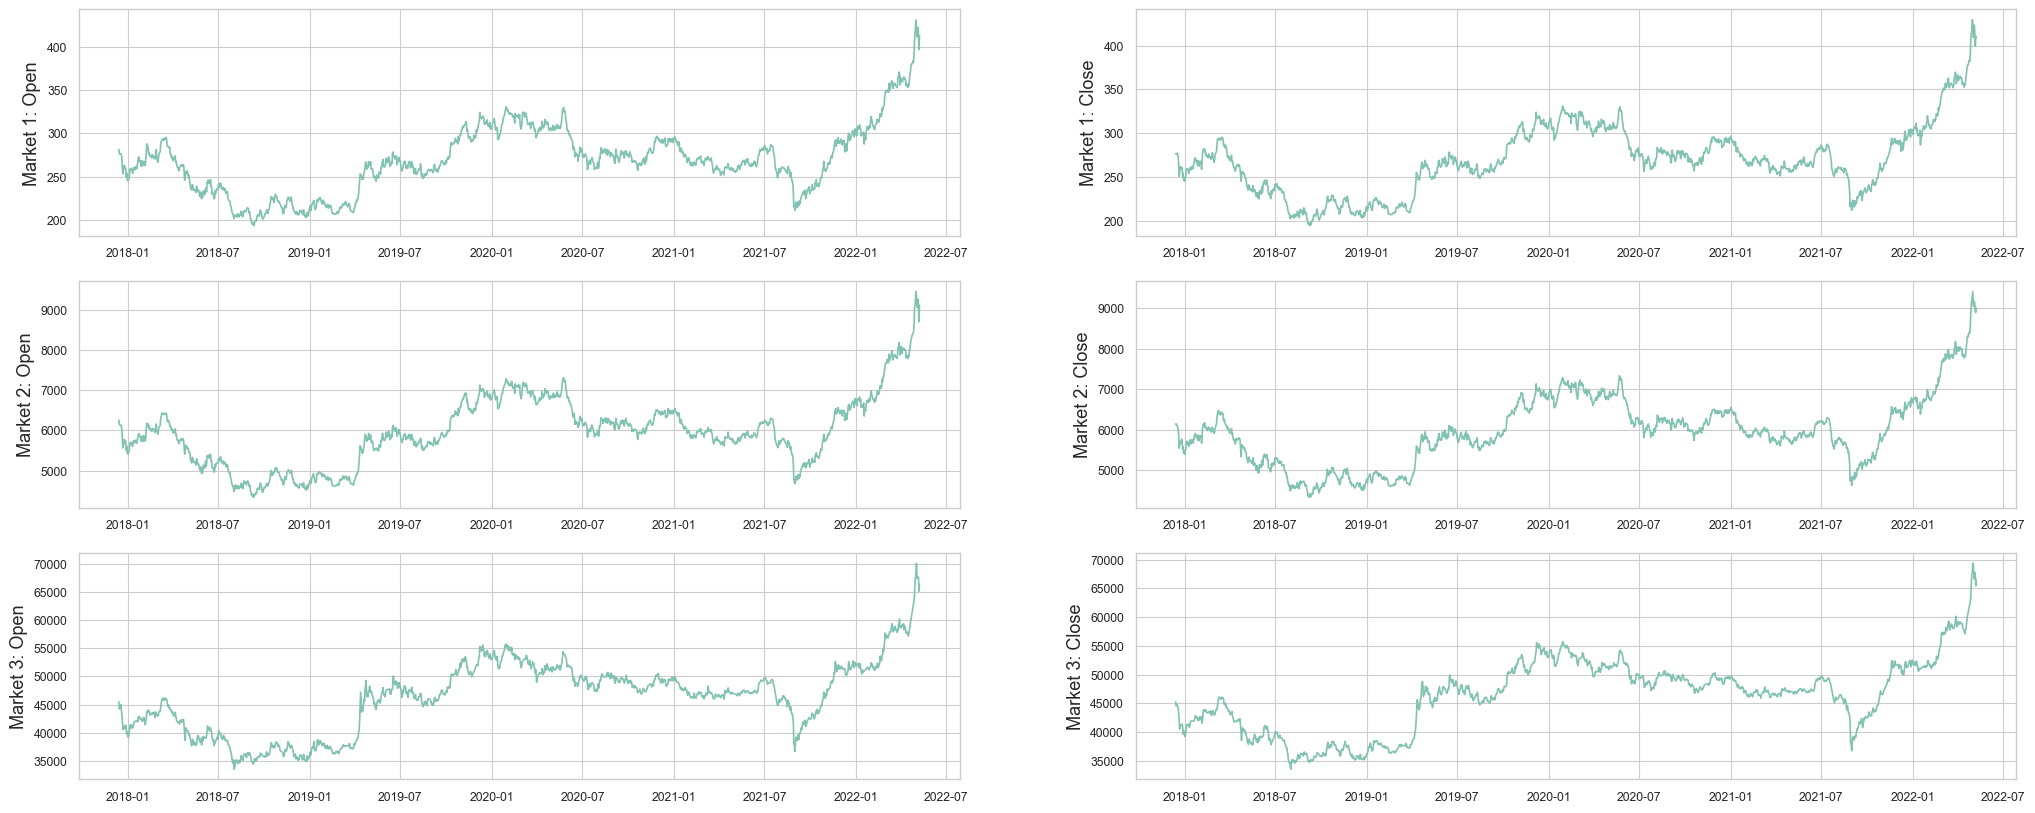

In [10]:
markets_no = 3
metrics_no = 2
metrics_names = ['open_', 'close_']

fig, axs = plt.subplots(markets_no, metrics_no, figsize=(25, 10))
for i in range(markets_no):
    for j in range(metrics_no):
        sns.lineplot(data=df, x='date', y=(metrics_names[j] + str(i+1)), ax=axs[i, j])
        axs[i, j].set(ylabel=f'Market {i+1}: {metrics_names[j][:-1].capitalize()}', 
                      xlabel='')
plt.show()

### Volume and open interest

The plots below show how the volume, open interest and their 10-day moving averages for 2nd and 3rd markets have been changing over time. The variance of volume for both markets dicreases with time. Furthermore, volumes recorded at both markets are slightly correlated with the Pearson coefficient equal to 0.447. 

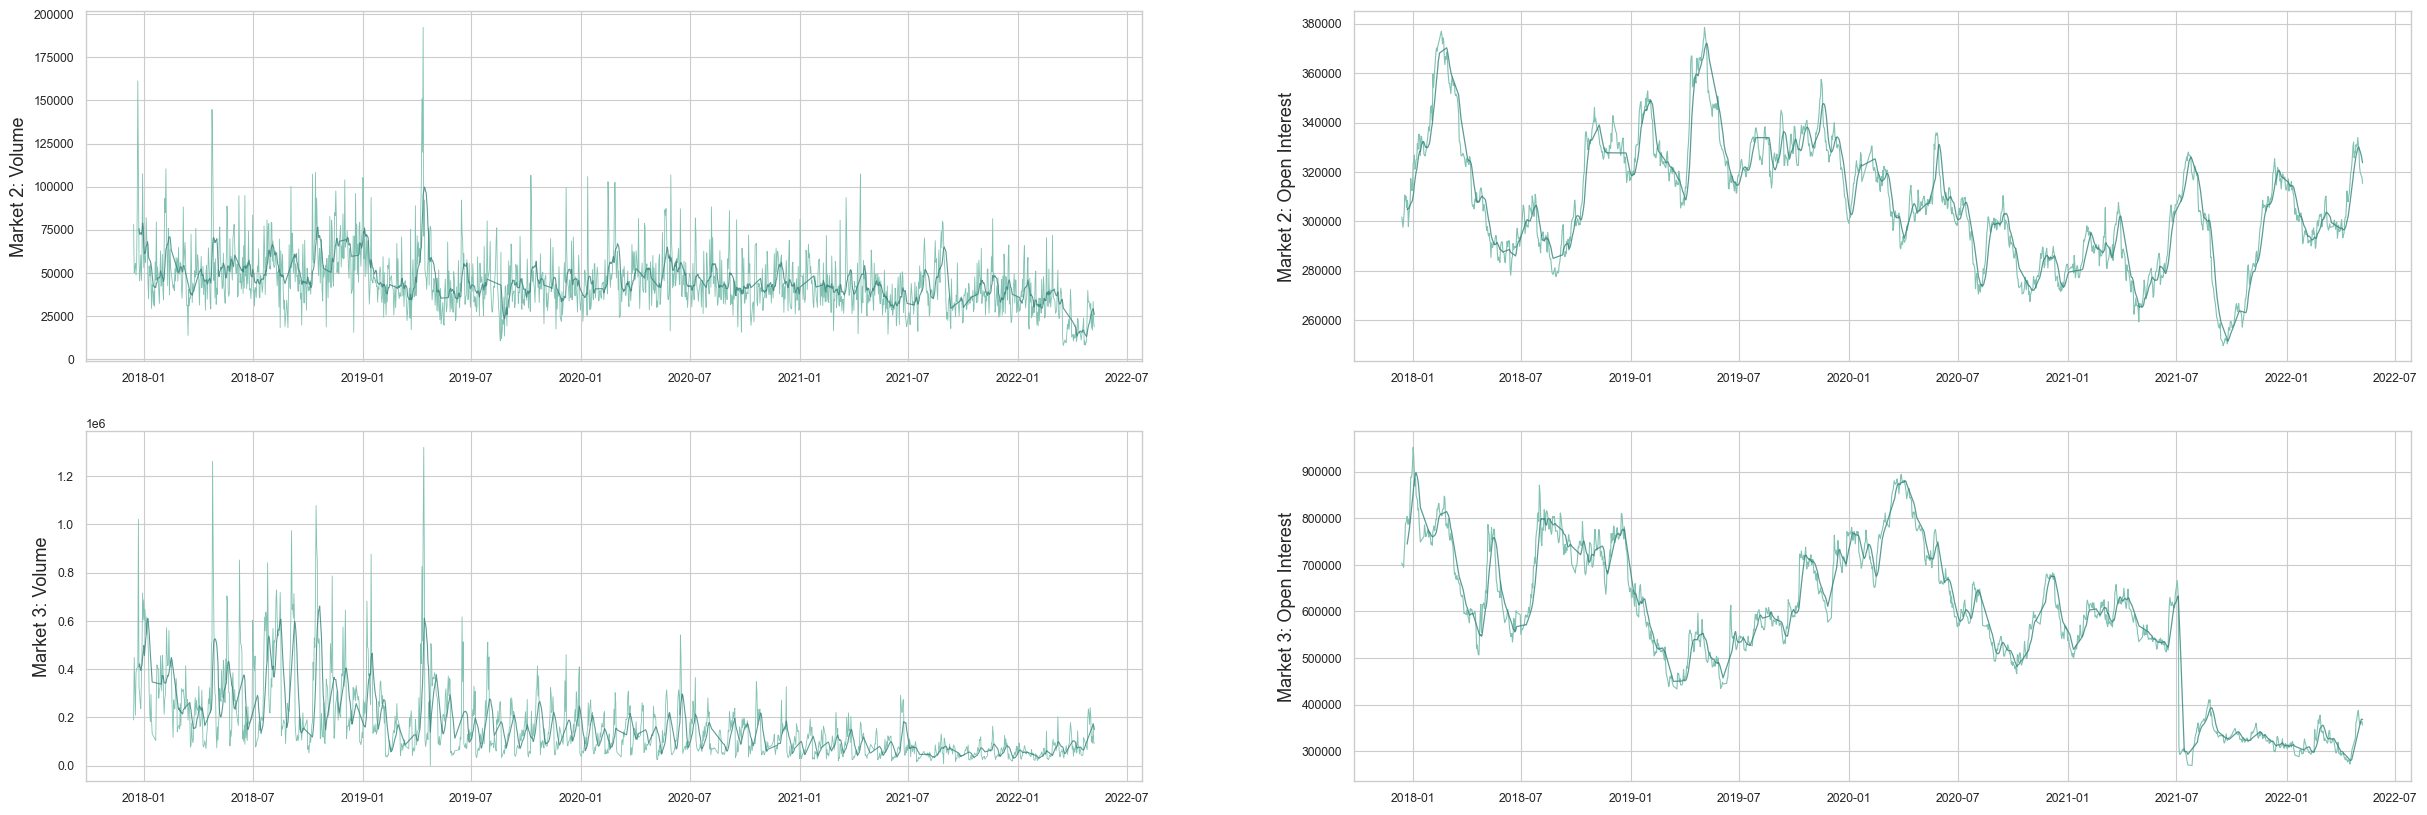

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(30, 10))
for i in range(2):
    sns.lineplot(data=df, x='date', y=f'volume_{i+2}', ax=axs[i, 0], linewidth = 0.6)
    sns.lineplot(x=df['date'], y=df[f'volume_{i+2}'].rolling(10).mean(), ax=axs[i, 0], linewidth = 0.8, alpha=.8)
    axs[i, 0].set(ylabel=f'Market {i+2}: Volume', xlabel='')
    sns.lineplot(data=df, x='date', y=f'open_interest_{i+2}', ax=axs[i, 1], linewidth = 0.8)
    sns.lineplot(x=df['date'], y=df[f'open_interest_{i+2}'].rolling(10).mean(), ax=axs[i, 1], linewidth = 0.9, alpha=.8)
    axs[i, 1].set(ylabel=f'Market {i+2}: Open Interest', xlabel='')
plt.show()

In [12]:
df[['open_interest_2', 'volume_2', 'open_interest_3', 'volume_3']].rename(columns=cols_dict).corr()

Market2: Open Interest  Market2: Volume  \
Market2: Open Interest                   1.000            0.154   
Market2: Volume                          0.154            1.000   
Market3: Open Interest                   0.244            0.348   
Market3: Volume                          0.304            0.447   

                        Market3: Open Interest  Market3: Volume  
Market2: Open Interest                   0.244            0.304  
Market2: Volume                          0.348            0.447  
Market3: Open Interest                   1.000            0.436  
Market3: Volume                          0.436            1.000

### Variables distribution

The boxplots below present the distribution of each attribute in the dataset. Despie the fact that most values seem roughly homogenos, the market 1 high price and market 3 low price contains some extreme observations which must be measurements errors. To ensure that, each outlier and its 2 nearest past and future observations were investigated.

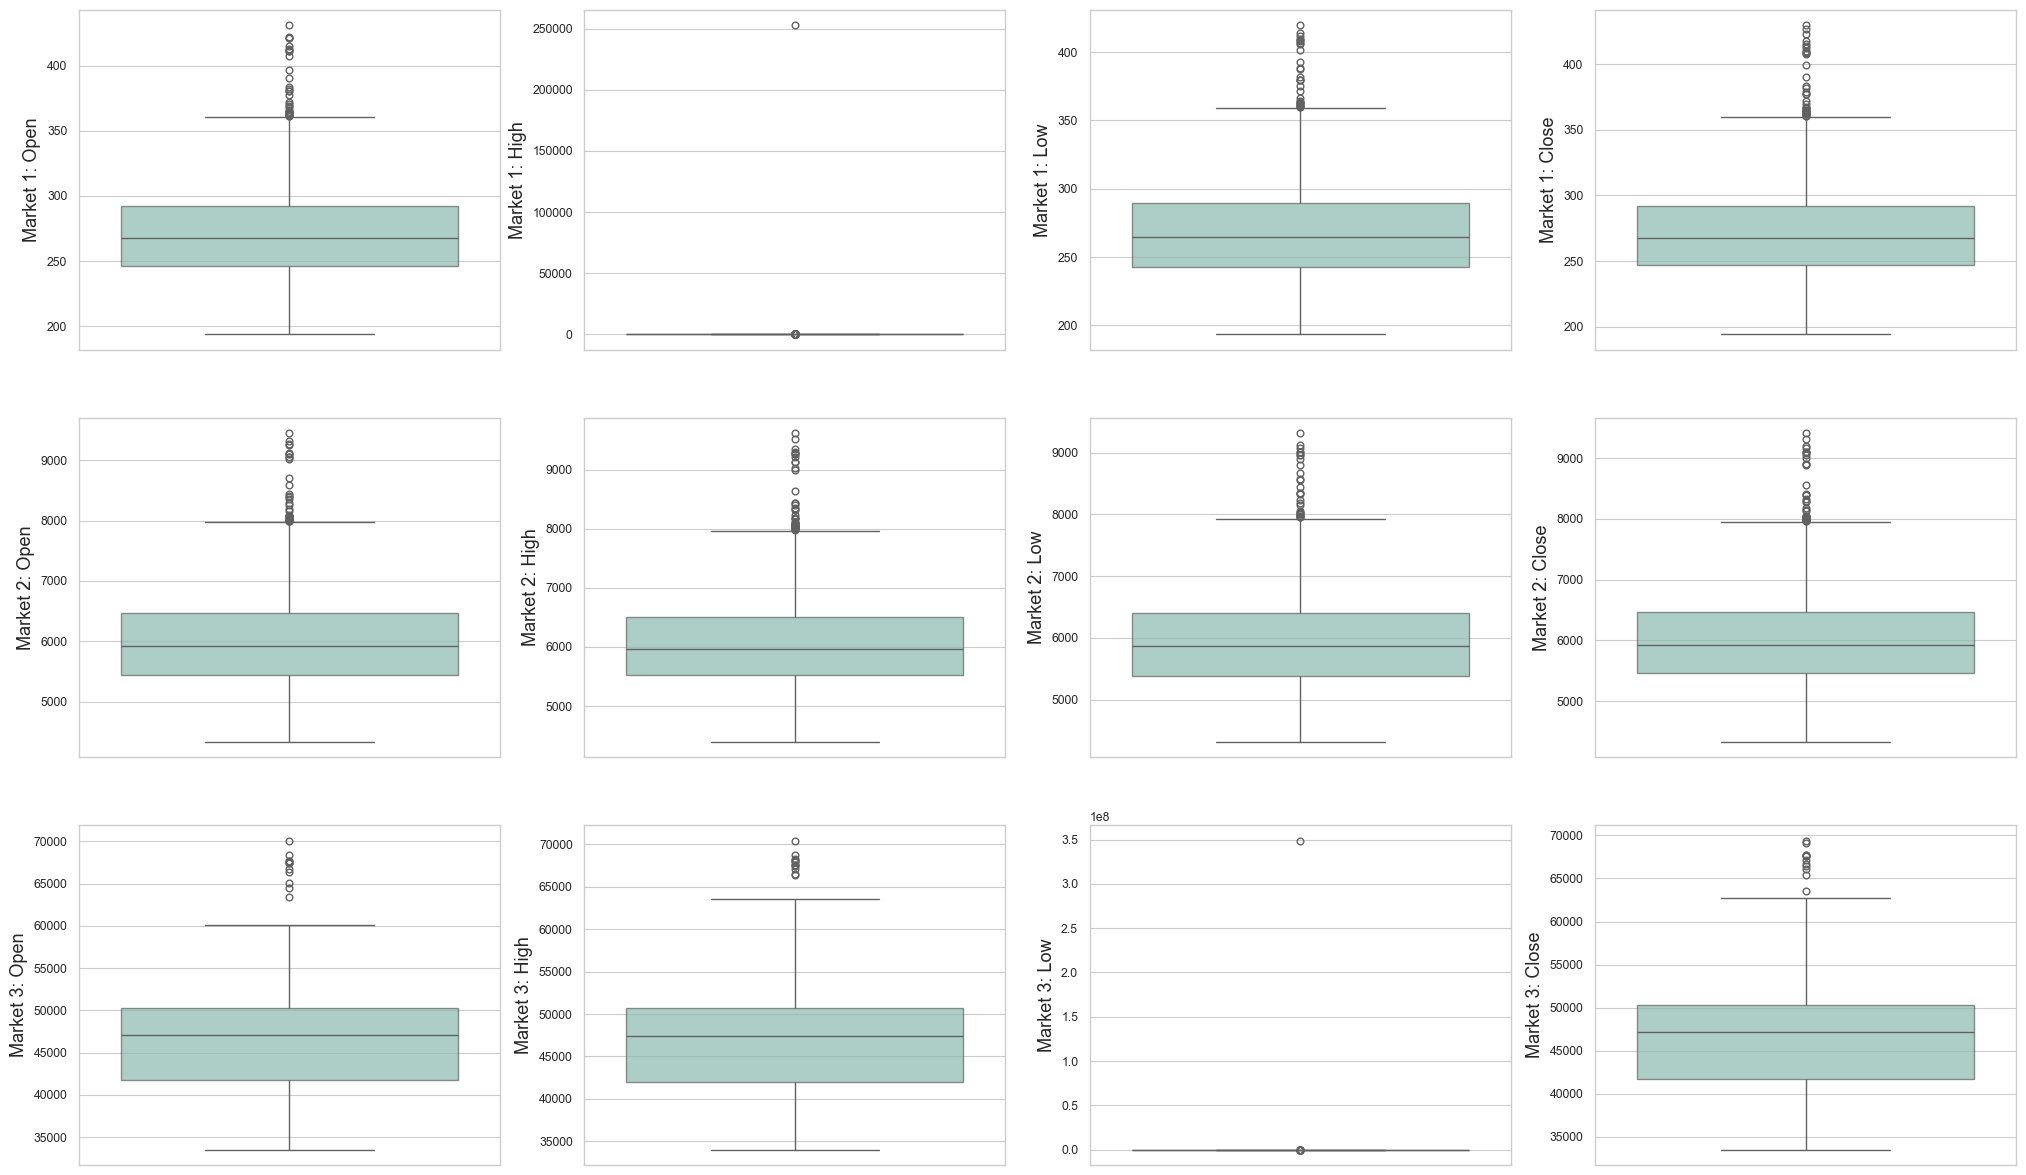

In [13]:
metrics_no = 4
metrics_names = ['open_', 'high_', 'low_', 'close_']

fig, axs = plt.subplots(markets_no, metrics_no, figsize=(25, 15))

for i in range(markets_no):
    for j in range(metrics_no):
        sns.boxplot(data=df, y=(metrics_names[j] + str(i+1)), ax=axs[i, j], boxprops=dict(alpha=0.7))
        axs[i, j].set(ylabel=f'Market {i + 1}: {metrics_names[j][:-1].capitalize()}', xlabel='')
plt.show()

After checking the outlier values for highest price at 2nd market and lowest price at 3rd market, it is not hard to notice, that numbers look similar to its neighbours but have higher order of magnitude. Because of that, it was decided, to divide both values accordingly, to make the values having the same scale as the remaining values in the column.

In [14]:
n = 2
idx = df[(df['high_1'] > 5000)].index
df.iloc[(idx[0] - n):(idx[0] + n + 1)]['high_1']

605      265.050
606      261.750
607   252743.000
608      252.700
609      253.500
Name: high_1, dtype: float64

In [15]:
df['high_1'] = np.where(df['high_1'] > 50000, df['high_1'] / 1000, df['high_1'])

In [16]:
idx = df[(df['low_3'] > 500000)].index
df.iloc[(idx[0] - n) : (idx[0] + n + 1)]['low_3']

241       34580.000
242       34480.000
243   348700000.000
244       34880.000
245       35730.000
Name: low_3, dtype: float64

In [17]:
df['low_3'] = np.where(df['low_3'] > 500000, df['low_3'] / 10000, df['low_3'])

After handling extremely high values, it was noticed that 1st market highest prices distribution has one more abnormally low value. After checking it, no pattern was found, so the value was considered as missing and replaced with NaN.

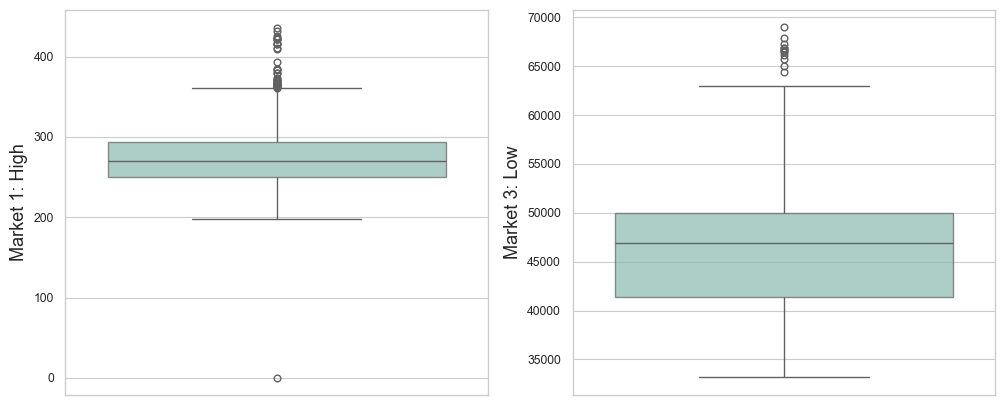

In [18]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df, y="high_1", ax=axs[0], boxprops=dict(alpha=0.7))
axs[0].set(ylabel='Market 1: High', xlabel='')
sns.boxplot(data=df, y="low_3", ax=axs[1], boxprops=dict(alpha=0.7))
axs[1].set(ylabel='Market 3: Low', xlabel='')
plt.show()

In [19]:
idx = df[(df['high_1'] < 100)].index
df.iloc[(idx[0] - n) : (idx[0] + n + 1)]['high_1']

382   214.450
383   217.000
384     0.550
385   213.900
386   218.350
Name: high_1, dtype: float64

In [20]:
df['high_1'] = np.where(df['high_1'] < 100, np.NaN, df['high_1'])

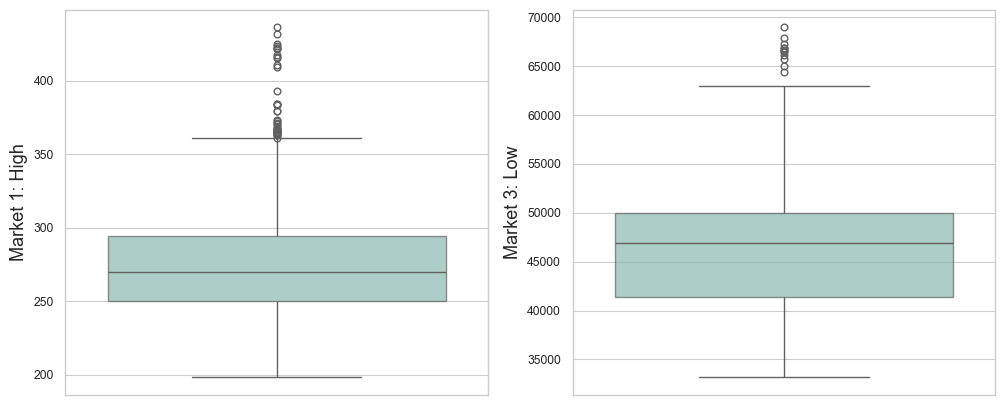

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))
sns.boxplot(data=df, y="high_1", ax=axs[0], boxprops=dict(alpha=0.7))
axs[0].set(ylabel='Market 1: High', xlabel='')
sns.boxplot(data=df, y="low_3", ax=axs[1], boxprops=dict(alpha=0.7))
axs[1].set(ylabel='Market 3: Low', xlabel='')
plt.show()

# 2. Replacing missing values

The analysed dataset contains many missing values which were imputed using the previous element. It is straightforward and commonly used method of imputing missing valeus in time series i nline with the assumption that we do not know the future values of the time series. The example entries before and after imputation are displayed below.

In [22]:
df[['close_2', 'high_2', 'low_2', 'open_2']].iloc[251:258]

close_2   high_2    low_2   open_2
251 4665.500 4745.000 4665.350 4745.000
252 4720.000 4720.150 4654.500 4678.000
253 4692.000 4721.000 4672.500 4718.000
254      NaN      NaN      NaN      NaN
255      NaN      NaN      NaN      NaN
256 4729.000 4750.000 4617.000 4639.000
257 4735.000 4746.000 4700.000 4726.000

In [23]:
df = df.ffill()

In [24]:
df[['close_2', 'high_2', 'low_2', 'open_2']].iloc[251:258]

close_2   high_2    low_2   open_2
251 4665.500 4745.000 4665.350 4745.000
252 4720.000 4720.150 4654.500 4678.000
253 4692.000 4721.000 4672.500 4718.000
254 4692.000 4721.000 4672.500 4718.000
255 4692.000 4721.000 4672.500 4718.000
256 4729.000 4750.000 4617.000 4639.000
257 4735.000 4746.000 4700.000 4726.000

In [25]:
df.isna().sum().sum()

0

# 3. Feature engineering

Machine learning models can be trained to predict the stock movements on historical market data including OHLC prices and volumes. Additionally, another common approach is to use technical indicators which may help to infer the behavior or trends of a time series. In the following sections some popular technical indicators were calculated and visualized to demosnstarte how the stock performance has been changing over the time.

## 3.1. Opening price movements

As the aim is to predict the directions of daily change of the stock open price, the target variable was categorized as "0 or "1", where "0" means that the next day’s open price
is lower than today’s open price, and "1" means that the next day’s price went up. It can be seen, that total counts when stock opening prices went up and down are very similar. 

In [26]:
df['outcome'] = (df['open_2'][1:].values > df['open_2'][:-1]).astype(int)
df[['open_2', 'outcome']].head(6)

open_2  outcome
0 6255.000    0.000
1 6150.000    0.000
2 6130.000    0.000
3 6126.500    1.000
4 6132.000    0.000
5 6096.000    0.000

In [27]:
df["outcome"] = df["outcome"].map({1: "Up", 0: "Down"})

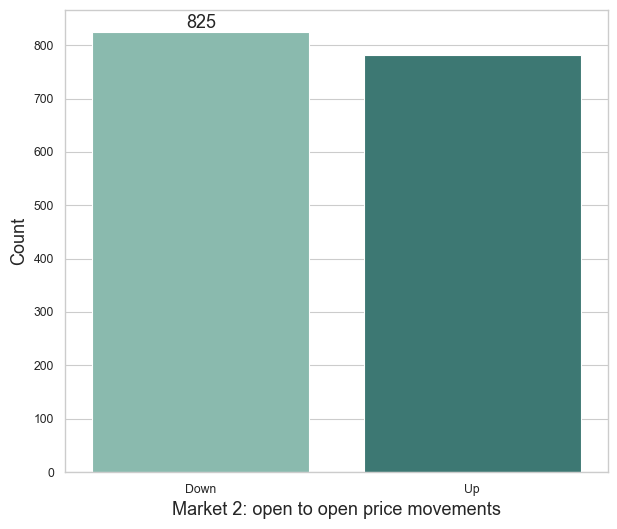

In [28]:
plt.figure(figsize=(7,6))
ax = sns.countplot(x='outcome', hue='outcome', data=df, order = df['outcome'].value_counts().index)
ax.set(xlabel="Market 2: open to open price movements", ylabel="Count")
ax.bar_label(ax.containers[0])
ax.get_legend().set_visible(False)
plt.show()

## 3.2. Daily returns

In the section below, the daily returns of closing and opening prices were calculated and displayed on the plots. One can notice, that periods of high volatility, when the closing prices were changing sharply, are usually common for all markets. As the closing price is ahead of opening price, to avoid **data leakage**, the daily returns were lagged.

In [29]:
def log_daily_return(v):
    return np.log(v[1:] / v[:-1].values)

for i in range(markets_no):
    df[f'return_op_{i+1}'] = log_daily_return(df[f'open_{i+1}'])
    df[f'return_cl_{i+1}'] = log_daily_return(df[f'close_{i+1}'])

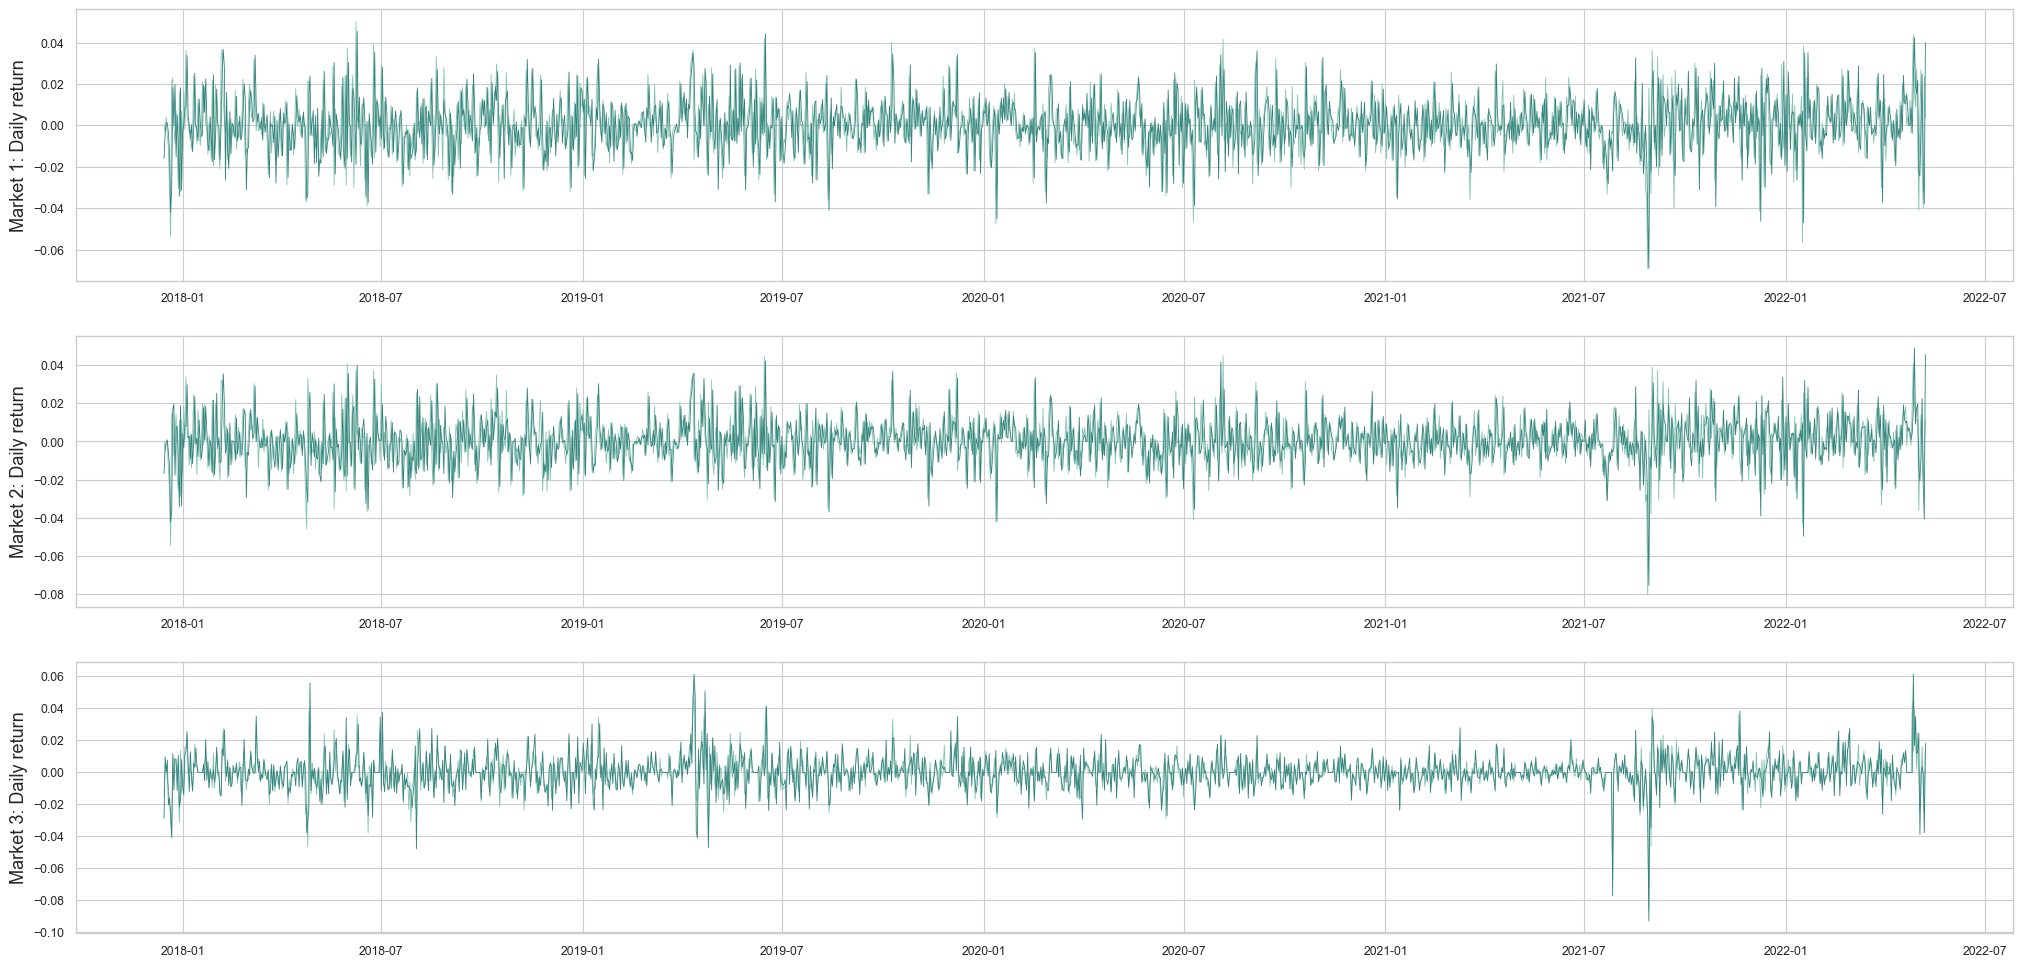

In [30]:
fig, axs = plt.subplots(markets_no, 1, figsize=(25, 12))

for i in range(markets_no):
    sns.lineplot(data=df, x='date', y=f'return_cl_{i+1}', ax=axs[i], linewidth = 0.6, color=palette[0])
    sns.lineplot(data=df, x='date', y=f'return_op_{i+1}', ax=axs[i], linewidth = 0.6, color=palette[1])
    axs[i].set(ylabel=f'Market {i+1}: Daily return', xlabel='')
plt.show()

In [31]:
for i in range(markets_no):
    df[f'return_cl_{i+1}_lag_1'] = df[f'return_cl_{i+1}'].shift(1)
    df[f'return_cl_{i+1}_lag_2'] = df[f'return_cl_{i+1}'].shift(2)
    cols_dict[f'return_cl_{i+1}_lag_1'] = f'M{i+1}: Daily return close lag(1)'
    cols_dict[f'return_cl_{i+1}_lag_2'] = f'M{i+1}: Daily return close lag(2)'
    
    df[f'return_op_{i+1}_lag_1'] = df[f'return_op_{i+1}'].shift(1)
    df[f'return_op_{i+1}_lag_2'] = df[f'return_op_{i+1}'].shift(2)
    cols_dict[f'return_op_{i+1}_lag_1'] = f'M{i+1}: Daily return open lag(1)'
    cols_dict[f'return_op_{i+1}_lag_2'] = f'M{i+1}: Daily return open lag(2)'

In [32]:
for i in range(markets_no):
    df.drop(columns=[f'return_cl_{i+1}'], inplace=True)
    df.drop(columns=[f'return_op_{i+1}'], inplace=True)

On the histograms below, it can be noticed that distribution of daily returns on 1st and 2nd market differs from the distribution of daily returns on 3rd market. On 3rd market changes of prices are more stable and centered around the mean, what indicates that the dstribution is leptokurtic. Days when stock opening price went up were sometimes preceded by the day with positive daily return. In other words, the more close-to-close price increased the day before, the higher probability that movement in the same direction occure again. Nevertheless, this pattern is barely visible and most often the daily return from the previous day do not affect they opening price movements direction the next day. Because some processes may affect other processes only after some time, 1- and 2-day lags of daily returns were included in the dataset.

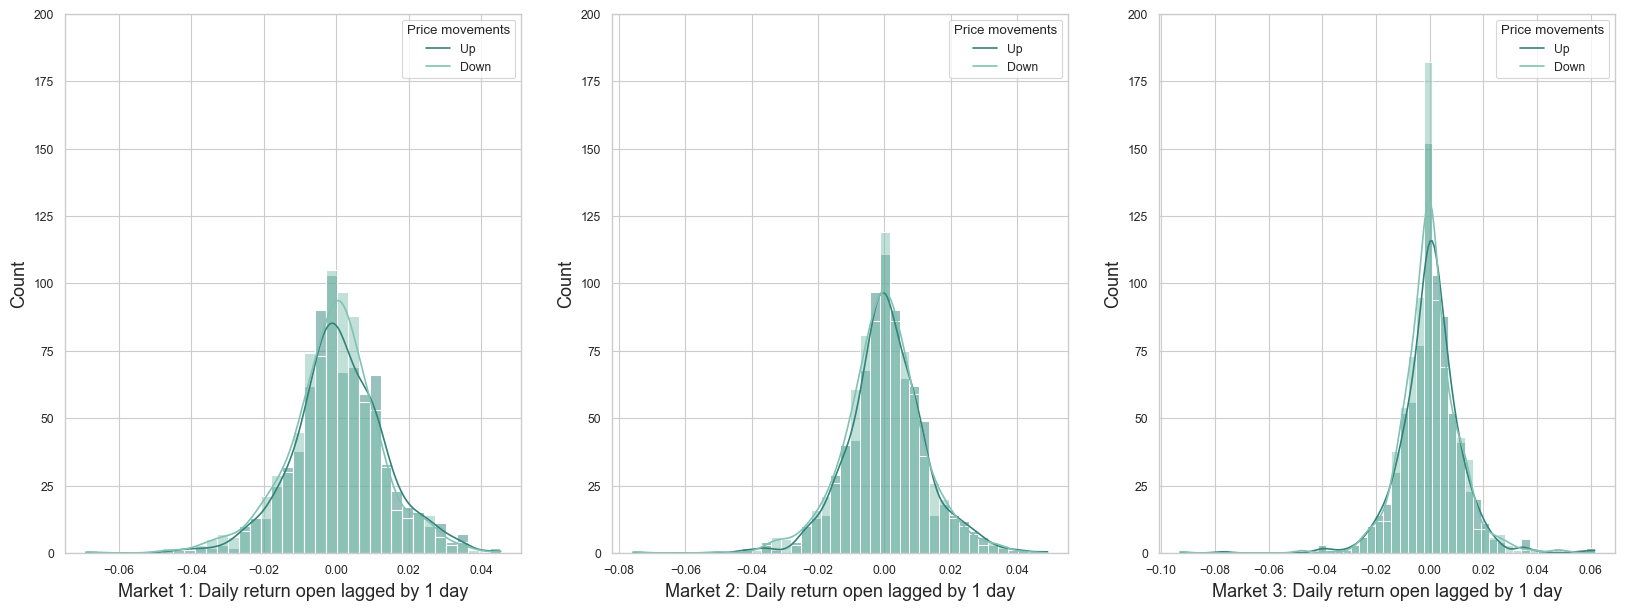

In [33]:
fig, axs = plt.subplots(1, markets_no, figsize=(20, 7))

for i in range(markets_no):
    sns.histplot(data=df, x=df[f'return_op_{i+1}_lag_1'], kde=True, hue='outcome', ax=axs[i], binwidth=0.003)
    axs[i].set(xlabel=f'Market {i+1}: Daily return open lagged by 1 day')
    axs[i].legend(title='Price movements', loc='upper right', labels=['Up', 'Down'])
    axs[i].set(ylim=(0, 200))
plt.show()

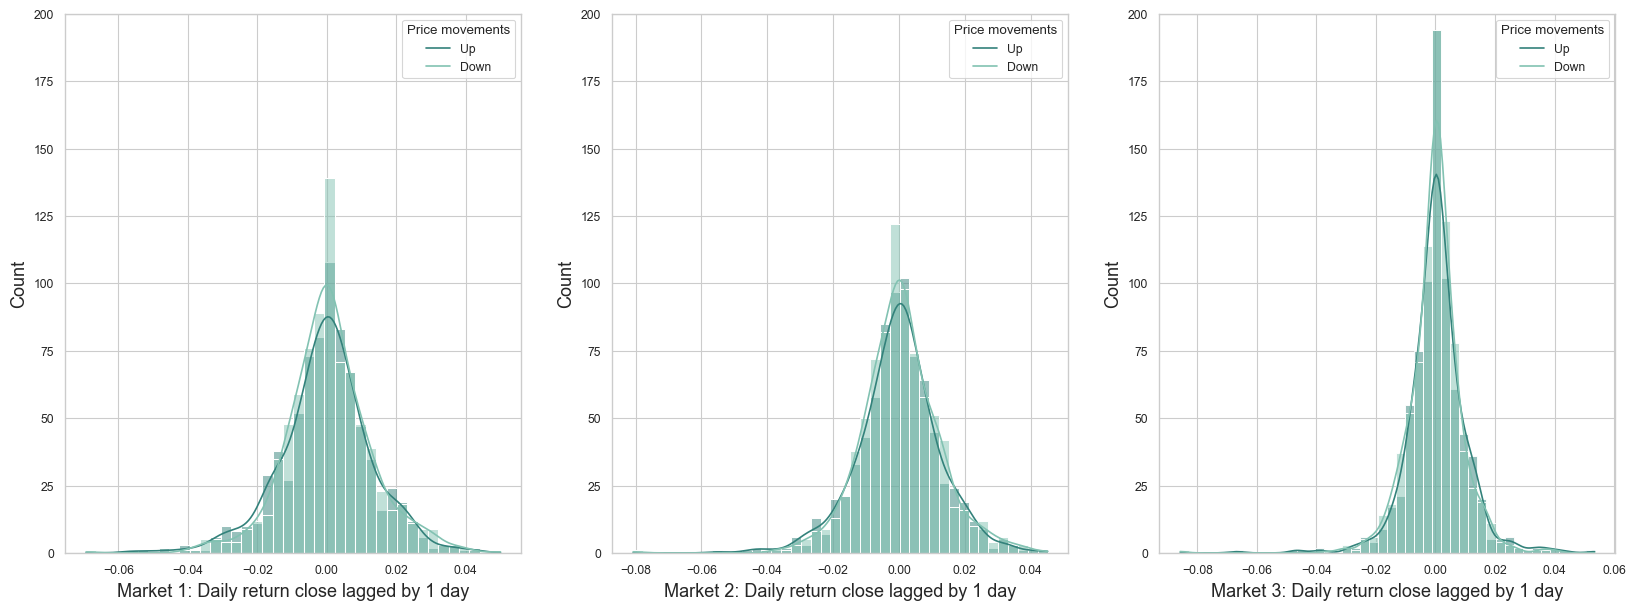

In [34]:
fig, axs = plt.subplots(1, markets_no, figsize=(20, 7))

for i in range(markets_no):
    sns.histplot(data=df, x=df[f'return_cl_{i+1}_lag_1'], kde=True, hue='outcome', ax=axs[i], binwidth=0.003)
    axs[i].set(xlabel=f'Market {i+1}: Daily return close lagged by 1 day')
    axs[i].legend(title='Price movements', loc='upper right', labels=['Up', 'Down'])
    axs[i].set(ylim=(0, 200))
plt.show()

The plot below provides additional information about relationship between price changes and their 1-day lags of all stocks. Closing price changes of market 1 and 2 are almost no correlated in the same period. No relationship can be observed between daily returns of market 3 and the two remaining markets at the same day, however, daily returns of market 3 are slighly more correlated with 1-day lag of market 1 and 2.

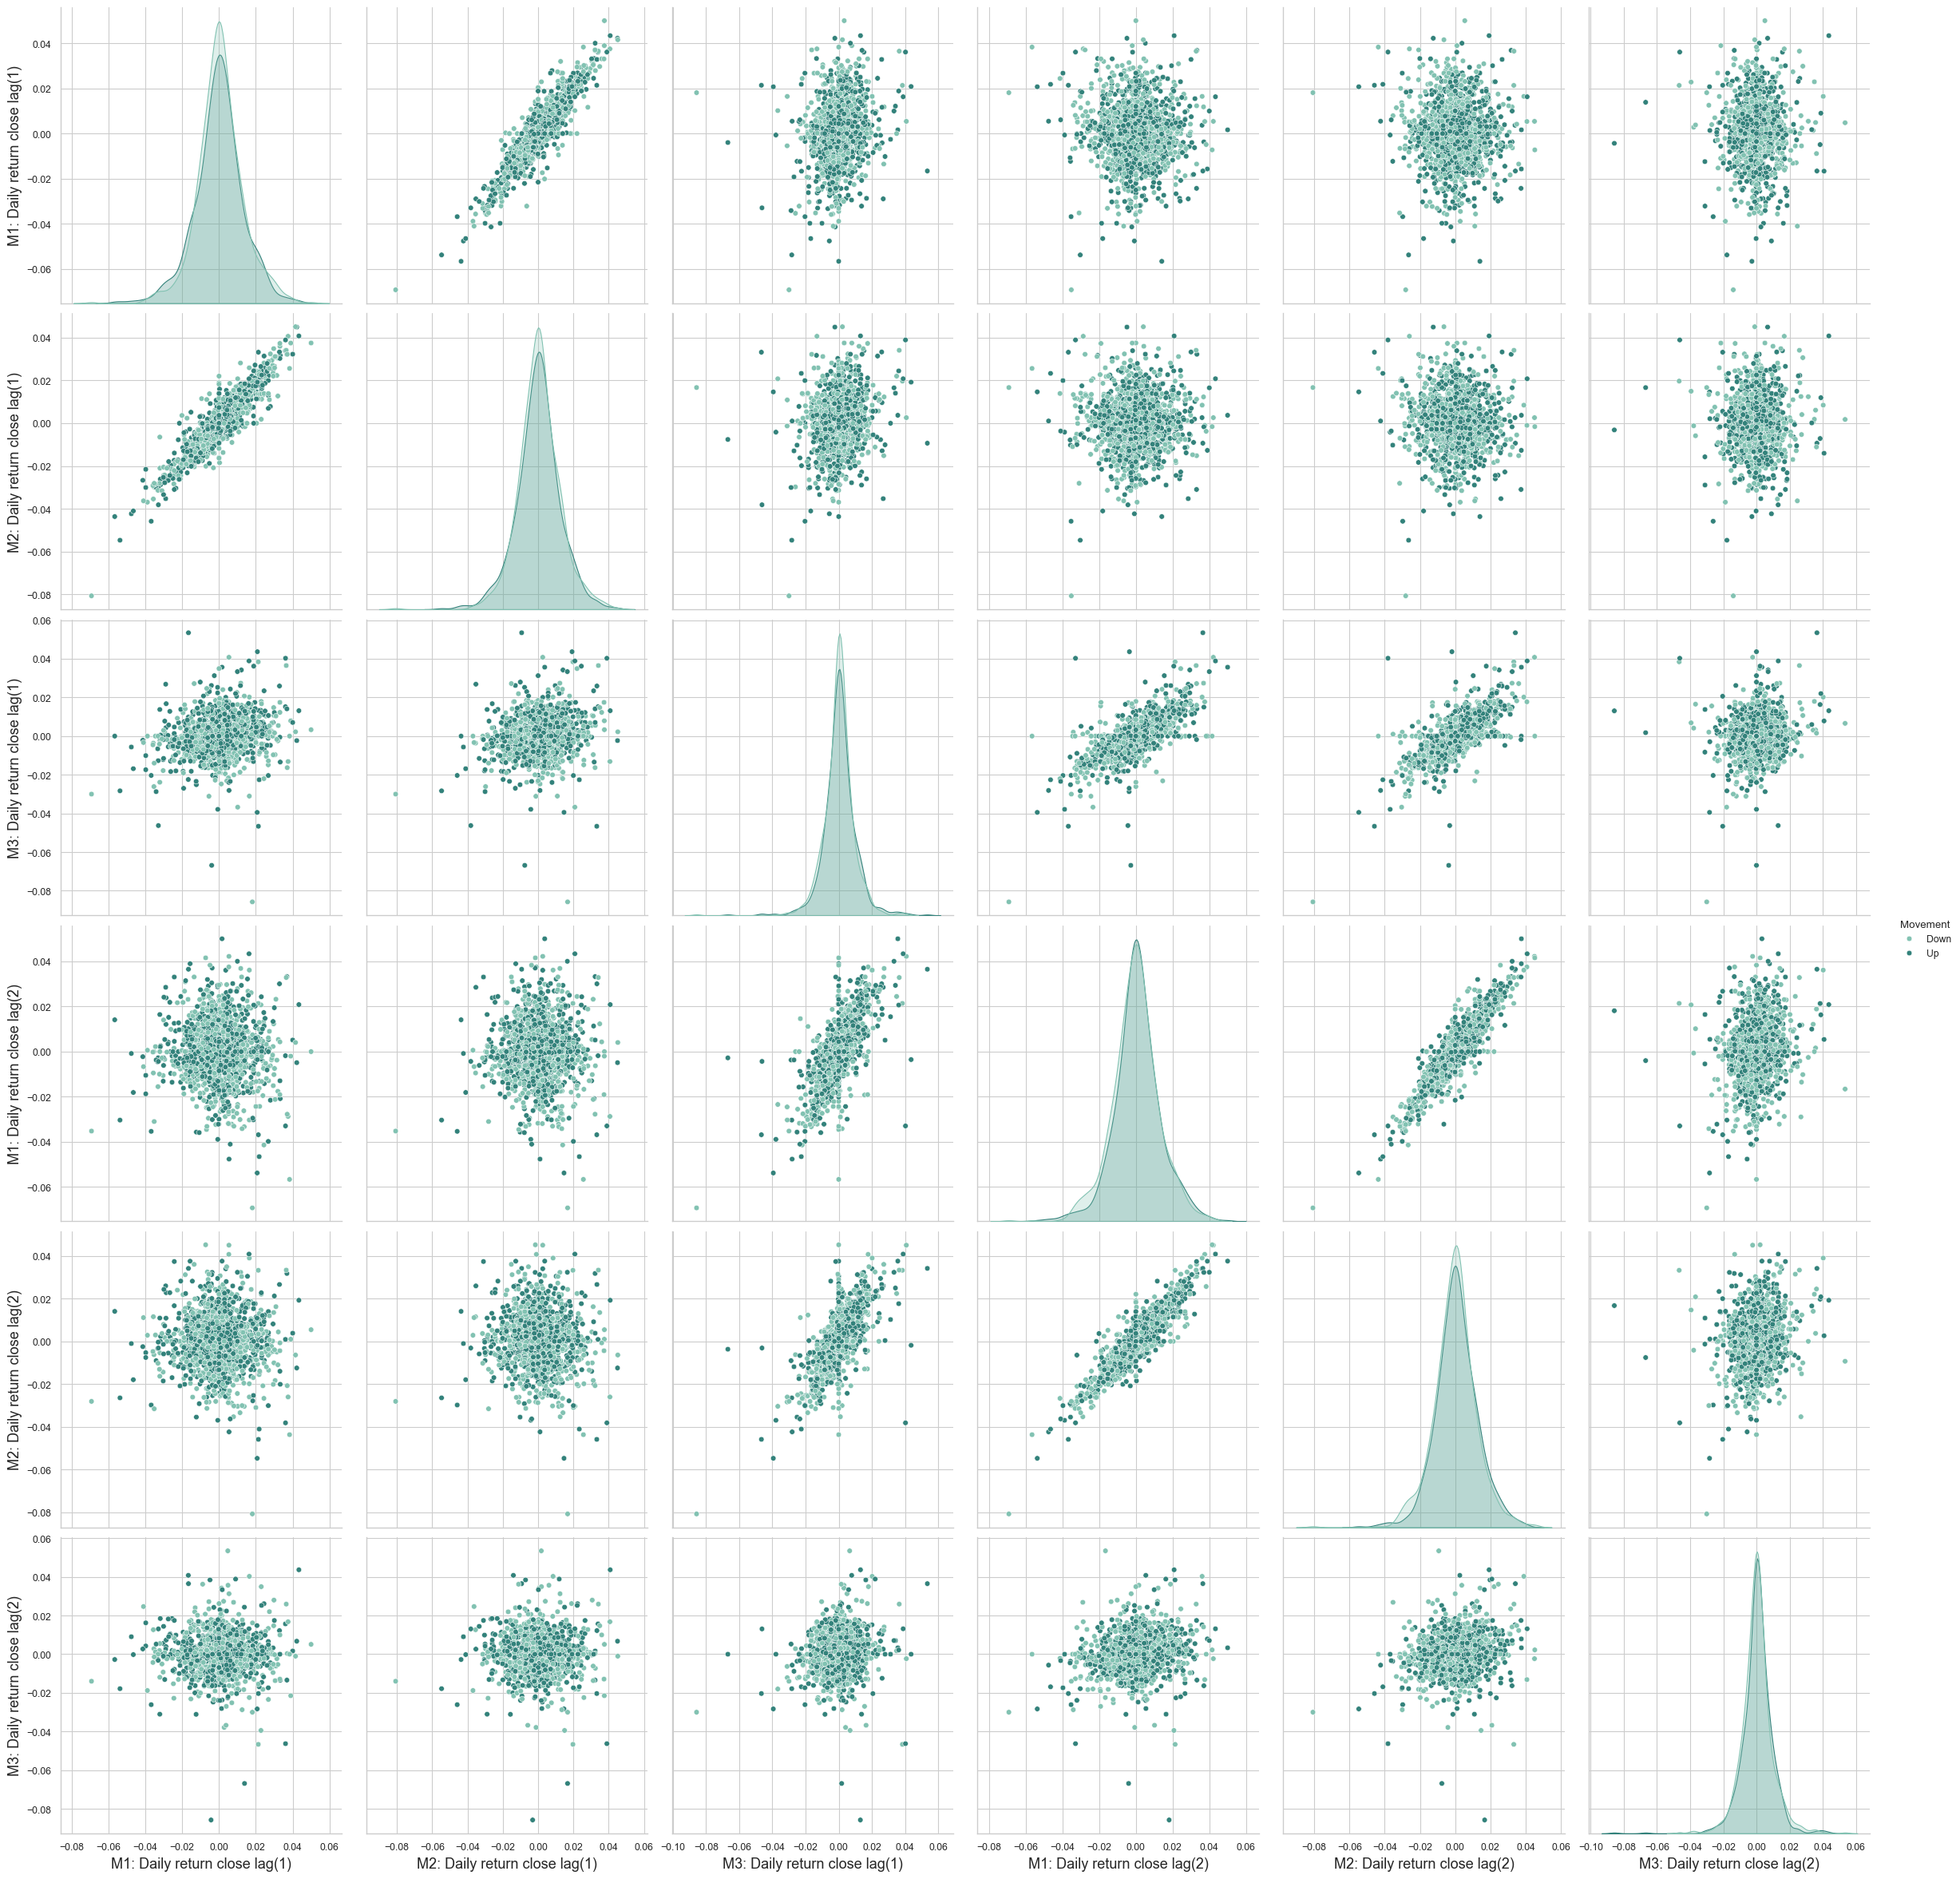

In [35]:
plot_df = df[['return_cl_1_lag_1', 'return_cl_2_lag_1', 'return_cl_3_lag_1', 'return_cl_1_lag_2', 'return_cl_2_lag_2', 'return_cl_3_lag_2', 'outcome']].copy().rename(cols_dict, axis=1)
g = sns.pairplot(plot_df, hue='outcome', height=4)
g._legend.set_title('Movement')

## 3.3. Technical indicators

In general, technical indicators are analysed and plotted to help some investors make their buy and sell decisions by providing information about the security’s price trends and performance. In this analysis technical indicators will be used as predictors when training the price movements classifier.

### Simple moving average

The simple moving avarage indicates the avarage trend of variable over a specific time period. It smooths abnormal signals and is calculated as an average taken from today and past n closing prices.

In [36]:
def MA(v, period):
    return v.rolling(period).mean()

ma_period = [1, 5, 10, 20, 40]

for i in range(markets_no):
    for period in ma_period:
        df[f'ma_{i+1}_{period}'] = MA(df[f'close_{i+1}'], period).shift(1)

### Exponential moving average

The exponential moving average gives higher weights to the latest data points which help to respond to price changes faster than a simple MA.

In [37]:
def EMA(v, period):
    ema = [sum(v[:period]) / period]
    for value in v[period:]:
        ema.append((value * (2 / (1 + period))) + ema[-1] * (1 - (2 / (1 + period))))
    return [np.nan] * (period - 1) + ema

for i in range(markets_no):
    for period in ma_period:
        df[f'ema_{i+1}_{period}'] = pd.Series(EMA(df[f'close_{i+1}'], period)).shift(1)

### Candlestick charts

The candlestick charts below show the OHLC price data and 2-week SMA and EMA of commodity from 1st and 2nd market over 2 first month of 2022. Price changes are very similar on both markets. There were hardly couple of days when the direction of open-to-close price changes as of the same date differed between the markets. One can also observe the trend of monthly SMA and EMA are mainly close to each other but start to deviate during periods when price trend change the direction.

In [38]:
d1 = datetime(2021, 12, 30)
d2 = datetime(2022, 2, 28)
candle_df = df[(df['date'] > d1) & (df['date'] < d2)]

In [39]:
prices = candle_df[['date', 'open_2', 'high_2', 'low_2', 'close_2']]
prices.columns = ['date', 'open', 'high', 'low', 'close']
up = prices[prices.close>=prices.open]
down = prices[prices.close<prices.open]

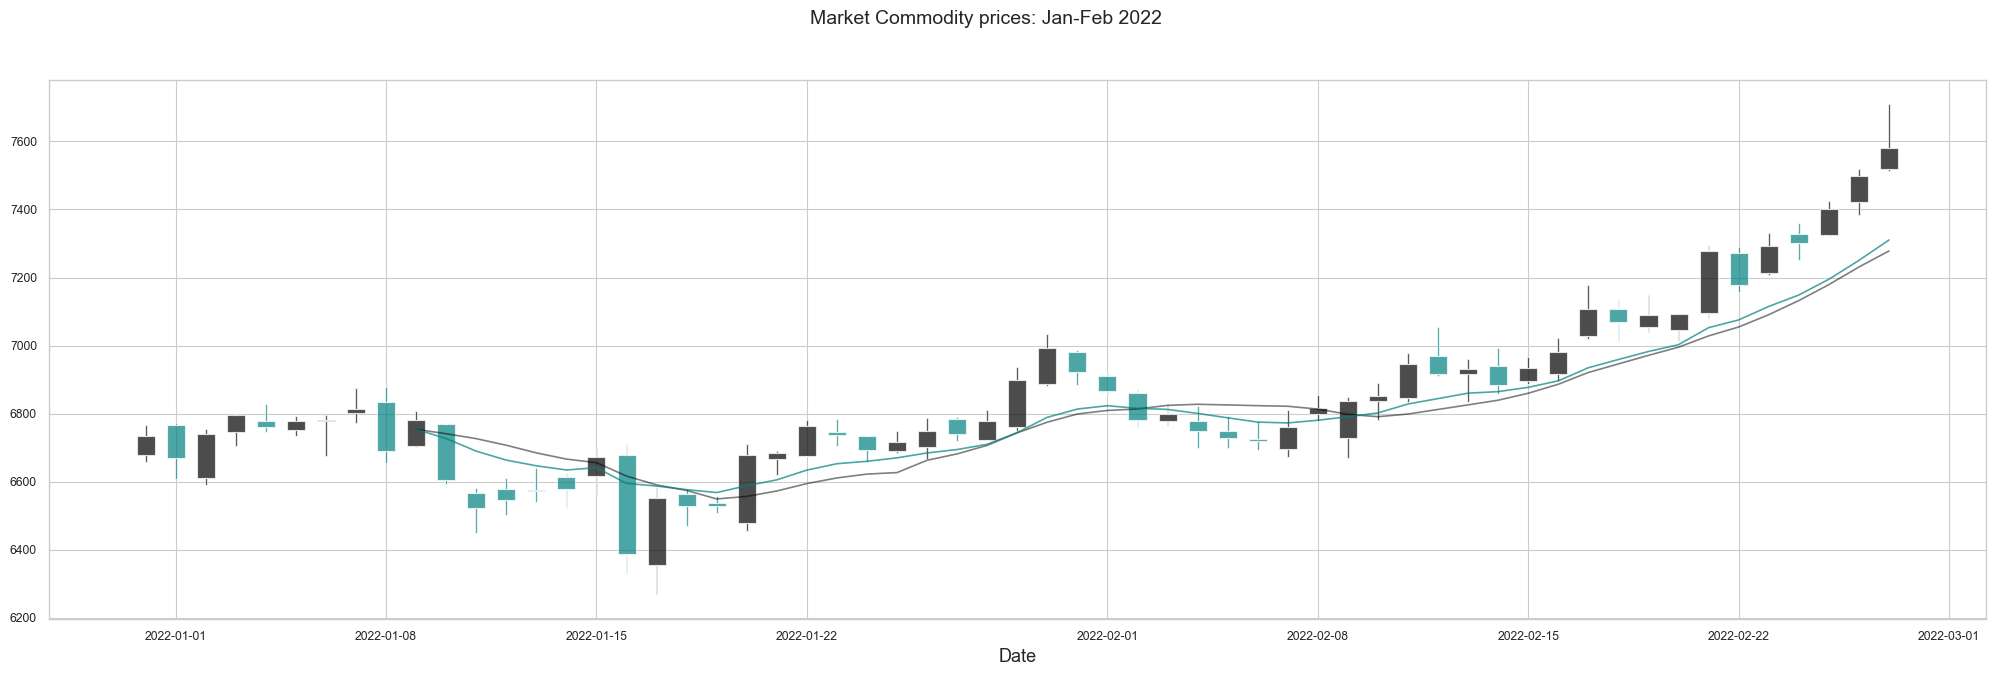

In [40]:
width = .6
width2 = .06
col1 = 'black'
col2 = 'teal'

fig, ax = plt.subplots(1, 1, figsize=(25, 7))
plt.bar(up['date'], up['close']-up['open'], width, bottom=up['open'], color=col1, alpha=.7)
plt.bar(up['date'], up['high']-up['close'], width2, bottom=up['close'], color=col1, alpha=.7)
plt.bar(up['date'], up['low']-up['open'], width2, bottom=up['open'], color=col1, alpha=.7)
plt.bar(down['date'],down['close']-down['open'], width, bottom=down['open'], color=col2, alpha=.7)
plt.bar(down['date'],down['high']-down['open'], width2, bottom=down['open'], color=col2, alpha=.7)
plt.bar(down['date'],down['low']-down['close'], width2, bottom=down['close'], color=col2, alpha=.7)
plt.plot(prices['date'], MA(prices['close'], 10), color=col1, alpha=.5)
plt.plot(prices['date'], EMA(prices['close'], 10), color=col2, alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('')
fig.suptitle('Market Commodity prices: Jan-Feb 2022', size=14)
plt.show()

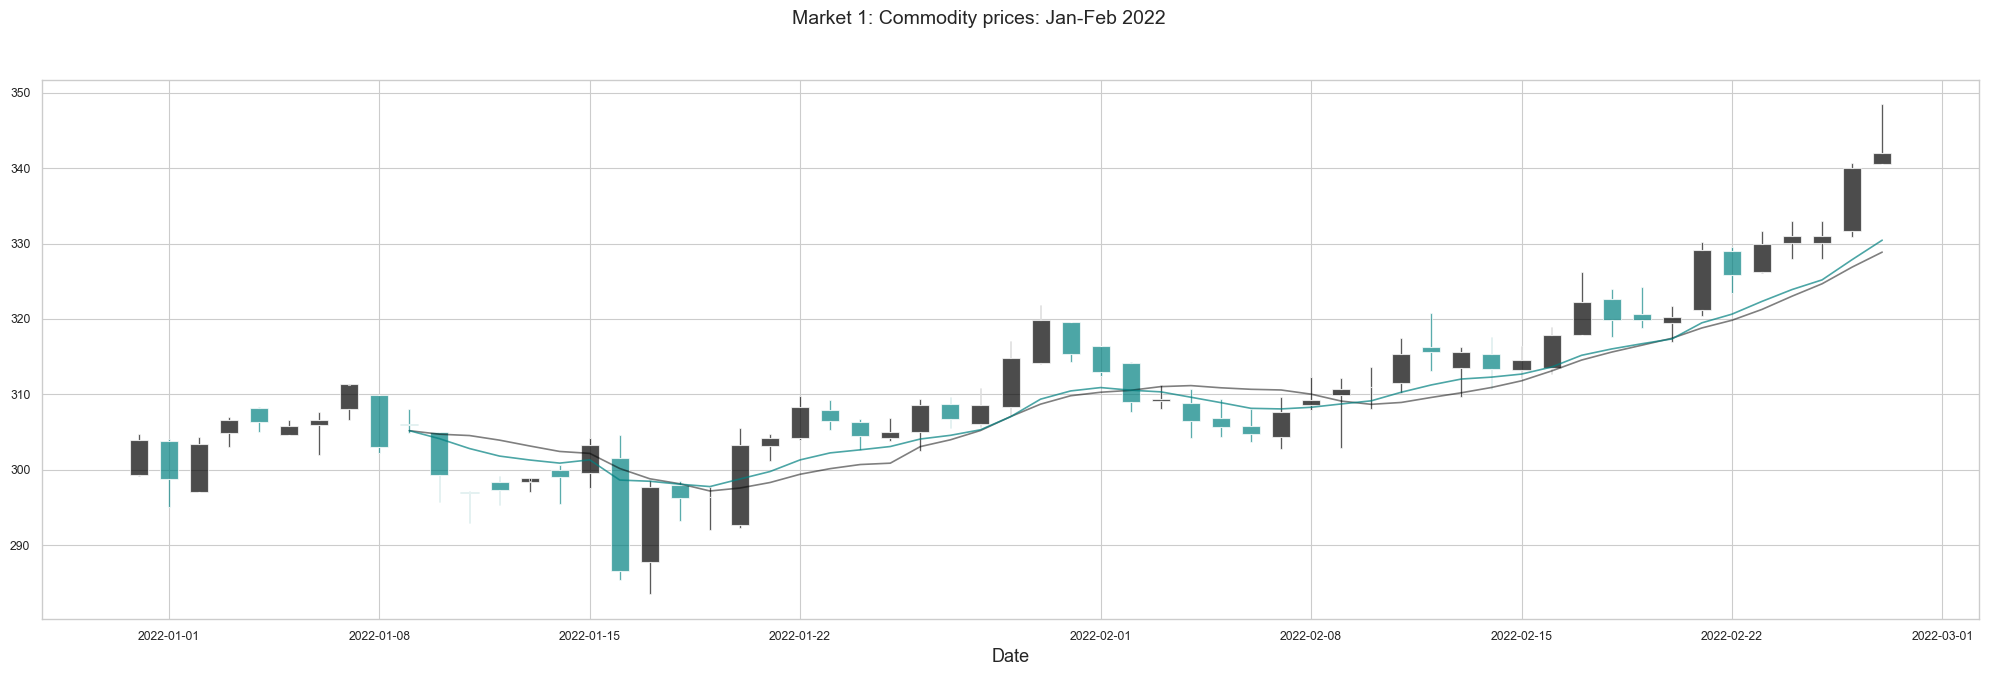

In [41]:
prices = candle_df[['date', 'open_1', 'high_1', 'low_1', 'close_1']]
prices.columns = ['date', 'open', 'high', 'low', 'close']
up = prices[prices.close>=prices.open]
down = prices[prices.close<prices.open]

fig, ax = plt.subplots(1, 1, figsize=(25, 7))
plt.bar(up['date'], up['close']-up['open'], width, bottom=up['open'], color=col1, alpha=.7)
plt.bar(up['date'], up['high']-up['close'], width2, bottom=up['close'], color=col1, alpha=.7)
plt.bar(up['date'], up['low']-up['open'], width2, bottom=up['open'], color=col1, alpha=.7)
plt.bar(down['date'],down['close']-down['open'], width, bottom=down['open'], color=col2, alpha=.7)
plt.bar(down['date'],down['high']-down['open'], width2, bottom=down['open'], color=col2, alpha=.7)
plt.bar(down['date'],down['low']-down['close'], width2, bottom=down['close'], color=col2, alpha=.7)
plt.plot(prices['date'], MA(prices['close'], 10), color=col1, alpha=.5)
plt.plot(prices['date'], EMA(prices['close'], 10), color=col2, alpha=.7)
ax.set_xlabel('Date')
ax.set_ylabel('')
fig.suptitle('Market 1: Commodity prices: Jan-Feb 2022', size=14)
plt.show()

### Relative strength index

RSI indicates whether an asset is strong and provides signals that tell investors to buy when the security is oversold and to sell it when it is overbought. It is given by the formula:

$$
RSI = 100 - \frac{100}{1 + RS}
$$

where $RS$ is given as the ratio of average higher closes gains to average lower closes losts. Stocks which have had more or stronger positive changes have a higher RSI than stocks which have had more or stronger negative changes. 

In [42]:
def RSI(v):
    v_diff = v.diff()
    v_diff.dropna(inplace=True)
    v_diff_up, v_diff_down = v_diff.copy(), v_diff.copy()

    v_diff_up[v_diff_up < 0] = 0
    v_diff_down[v_diff_down > 0] = 0

    avg_up = v_diff_up.rolling(14).mean()
    avg_down = v_diff_down.rolling(14).mean().abs()
    return avg_up / (avg_up + avg_down) * 100

for i in range(markets_no):
        df[f'rsi_{i+1}'] = RSI(df[f'close_{i+1}']). shift(1)

#### Moving average convergence/divergence

The moving average convergence/divergence indicator show the difference between the 26-period EMA and the 12-period EMA. It can provide two pieces of information: the trend direction of the stock price and the momentum of the share price.

$$
MACD = EMA_{12} - EMA_{26}
$$

In [43]:
def MACD(v):
    return np.subtract(EMA(v, 26), EMA(v, 12))

for i in range(markets_no):
        df[f'macd_{i+1}'] = pd.Series(MACD(df[f'close_{i+1}'])).shift(1)

The plot below shows closing prices of the commodity from all 3 markets and two techncial indicators: relative strength index and moving average convergence/divergence.

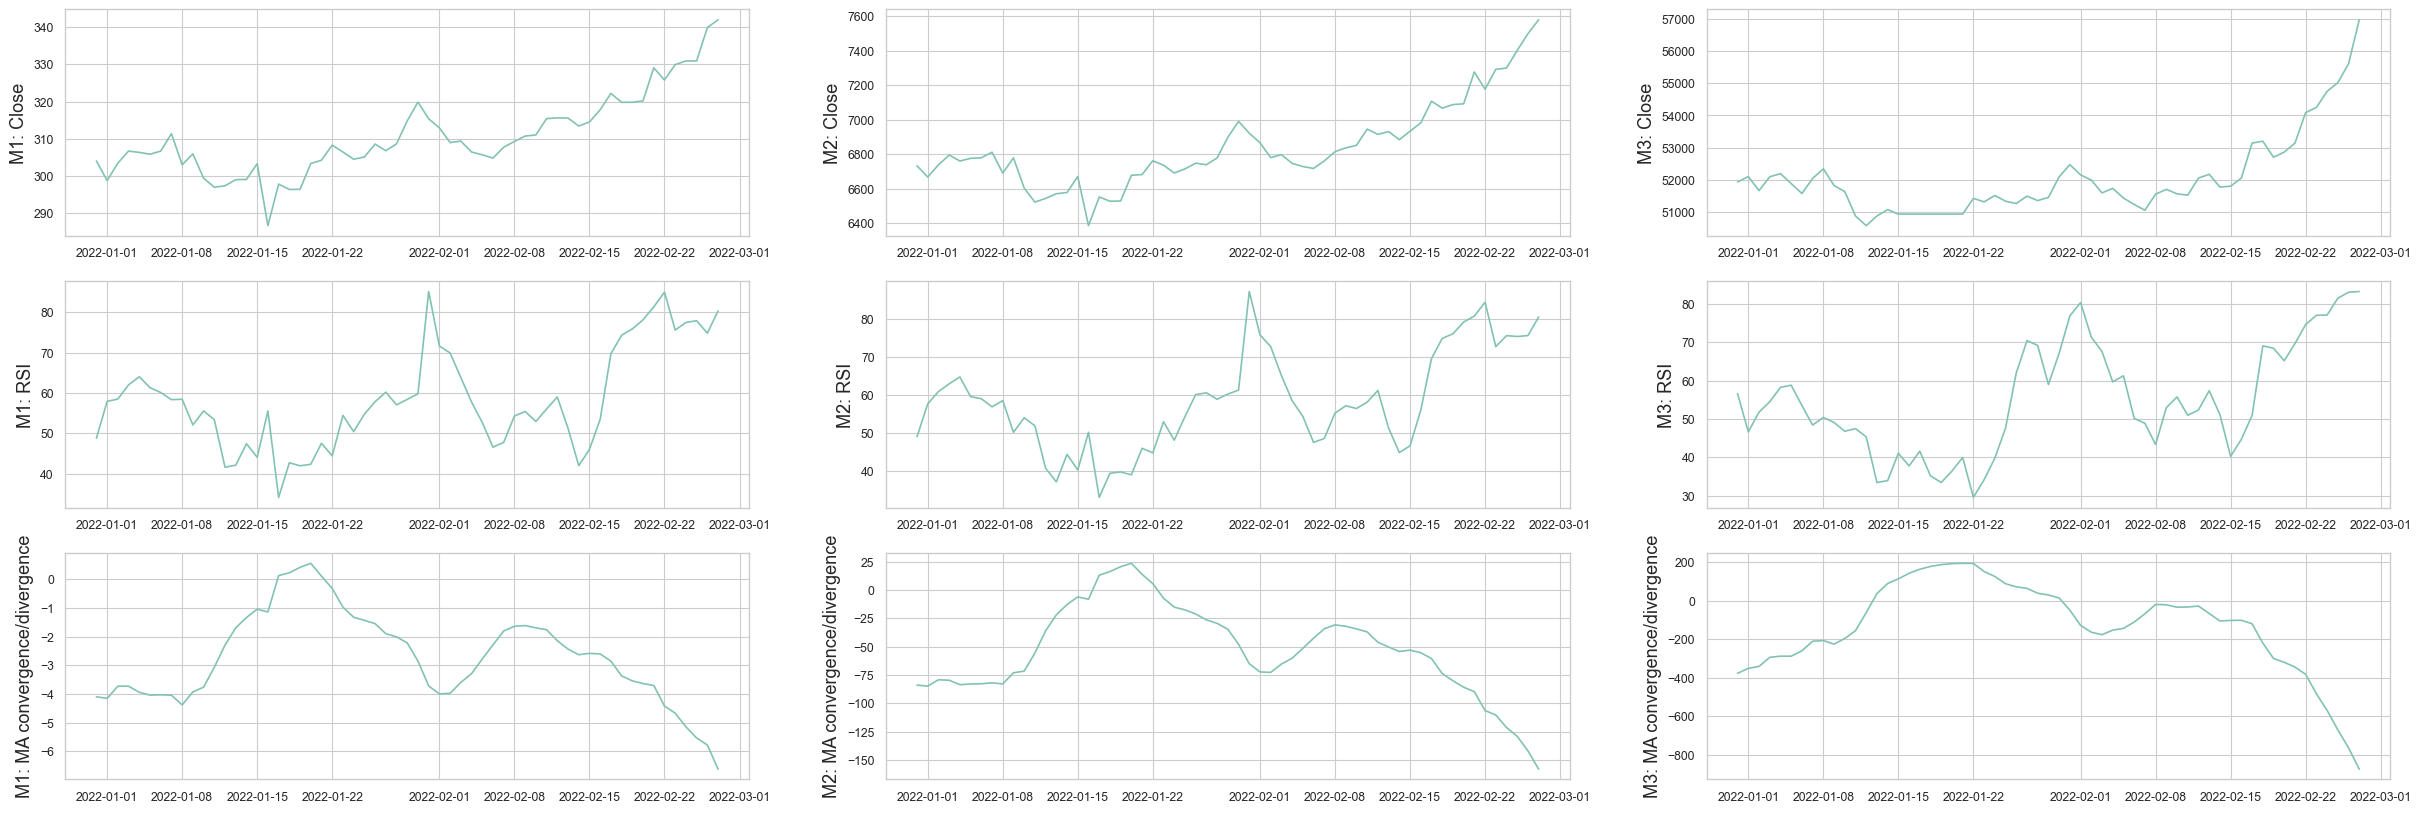

In [44]:
candle_df = df[(df['date'] > d1) & (df['date'] < d2)]
fig, axs = plt.subplots(3, markets_no, figsize=(30, 10))

for i in range(markets_no):
    sns.lineplot(data=candle_df, x='date', y=f'close_{i+1}', ax=axs[0, i])
    axs[0, i].set(ylabel=f'M{i+1}: Close', xlabel='')
    sns.lineplot(data=candle_df, x='date', y=f'rsi_{i+1}', ax=axs[1, i])
    axs[1, i].set(ylabel=f'M{i+1}: RSI', xlabel='')
    sns.lineplot(data=candle_df, x='date', y=f'macd_{i+1}', ax=axs[2, i])
    axs[2, i].set(ylabel=f'M{i+1}: MA convergence/divergence', xlabel='')
plt.show()

In [45]:
df["outcome"] = df["outcome"].map({"Up": 1, "Down": 0})

In [46]:
x, y = [], []
for i in range(3):
    for j in ma_period:
        x.append(f'ma_{i+1}_{j}')
        y.append(f'ema_{i+1}_{j}')
        cols_dict[f'ma_{i+1}_{j}'] = f'M{i+1}: {j}-day Simple MA'
        cols_dict[f'ema_{i+1}_{j}'] = f'M{i+1}: {j}-day Exponential MA'

df_corr_cols = ['outcome', 
                'return_cl_1_lag_1', 'return_cl_1_lag_2', 'return_op_1_lag_1', 'return_op_1_lag_2', 
                'return_cl_2_lag_1', 'return_cl_2_lag_2', 'return_op_2_lag_1', 'return_op_2_lag_2', 
                'return_cl_3_lag_1', 'return_cl_3_lag_2', 'return_op_3_lag_1', 'return_op_3_lag_2',
                'rsi_1', 'rsi_2', 'rsi_3', 'macd_1', 'macd_2',
                'macd_3']
pretty_cols = ['Outcome', 
              'M1: Daily returns close lag 1', 'M1: Daily returns close lag 2', 'M1: Daily returns open lag 1', 'M1: Daily returns open lag 2',
              'M2: Daily returns close lag 1', 'M2: Daily returns close lag 2', 'M2: Daily returns open lag 1', 'M2: Daily returns open lag 2',
              'M3: Daily returns close lag 1', 'M3: Daily returns close lag 2', 'M3: Daily returns open lag 1', 'M3: Daily returns open lag 2',
              'M1: RSI', 'M2: RSI', 'M3: RSI',
              'M1: MA Conv/div', 'M2: MA Conv/div', 'M3: MA Conv/div',]

for i in range(len(df_corr_cols)):
    cols_dict[df_corr_cols[i]] = pretty_cols[i]

Also the closing, minimum and maximum prices were shifted by 1 assuming that they only the opening price is known at particular day.

In [47]:
cols_to_shift = ['close_1', 'high_1', 'low_1',
                 'close_2', 'high_2', 'low_2',
                 'open_interest_2', 'volume_2', 'close_3', 
                 'high_3', 'low_3', 'open_interest_3', 'volume_3']
df[cols_to_shift] = df[cols_to_shift].shift(1)

# 4. Correlation analysis

The heatmap below describes the degree of linear relationship between each two features selected from the dataset. The highest correlation occuring between target variable and the daily returns but it is almost qual to 0 anyway. Other variables are even less correlated with the price movements. Additionally, daily returns of 1st and 2nd market are correlated with each other and with the 1-day lag of 3rd market returns. Strong, negative correlation characterizes RSI indeces with MACD indicators. Simple MA and EMA values of all markets are also correlated with each other.

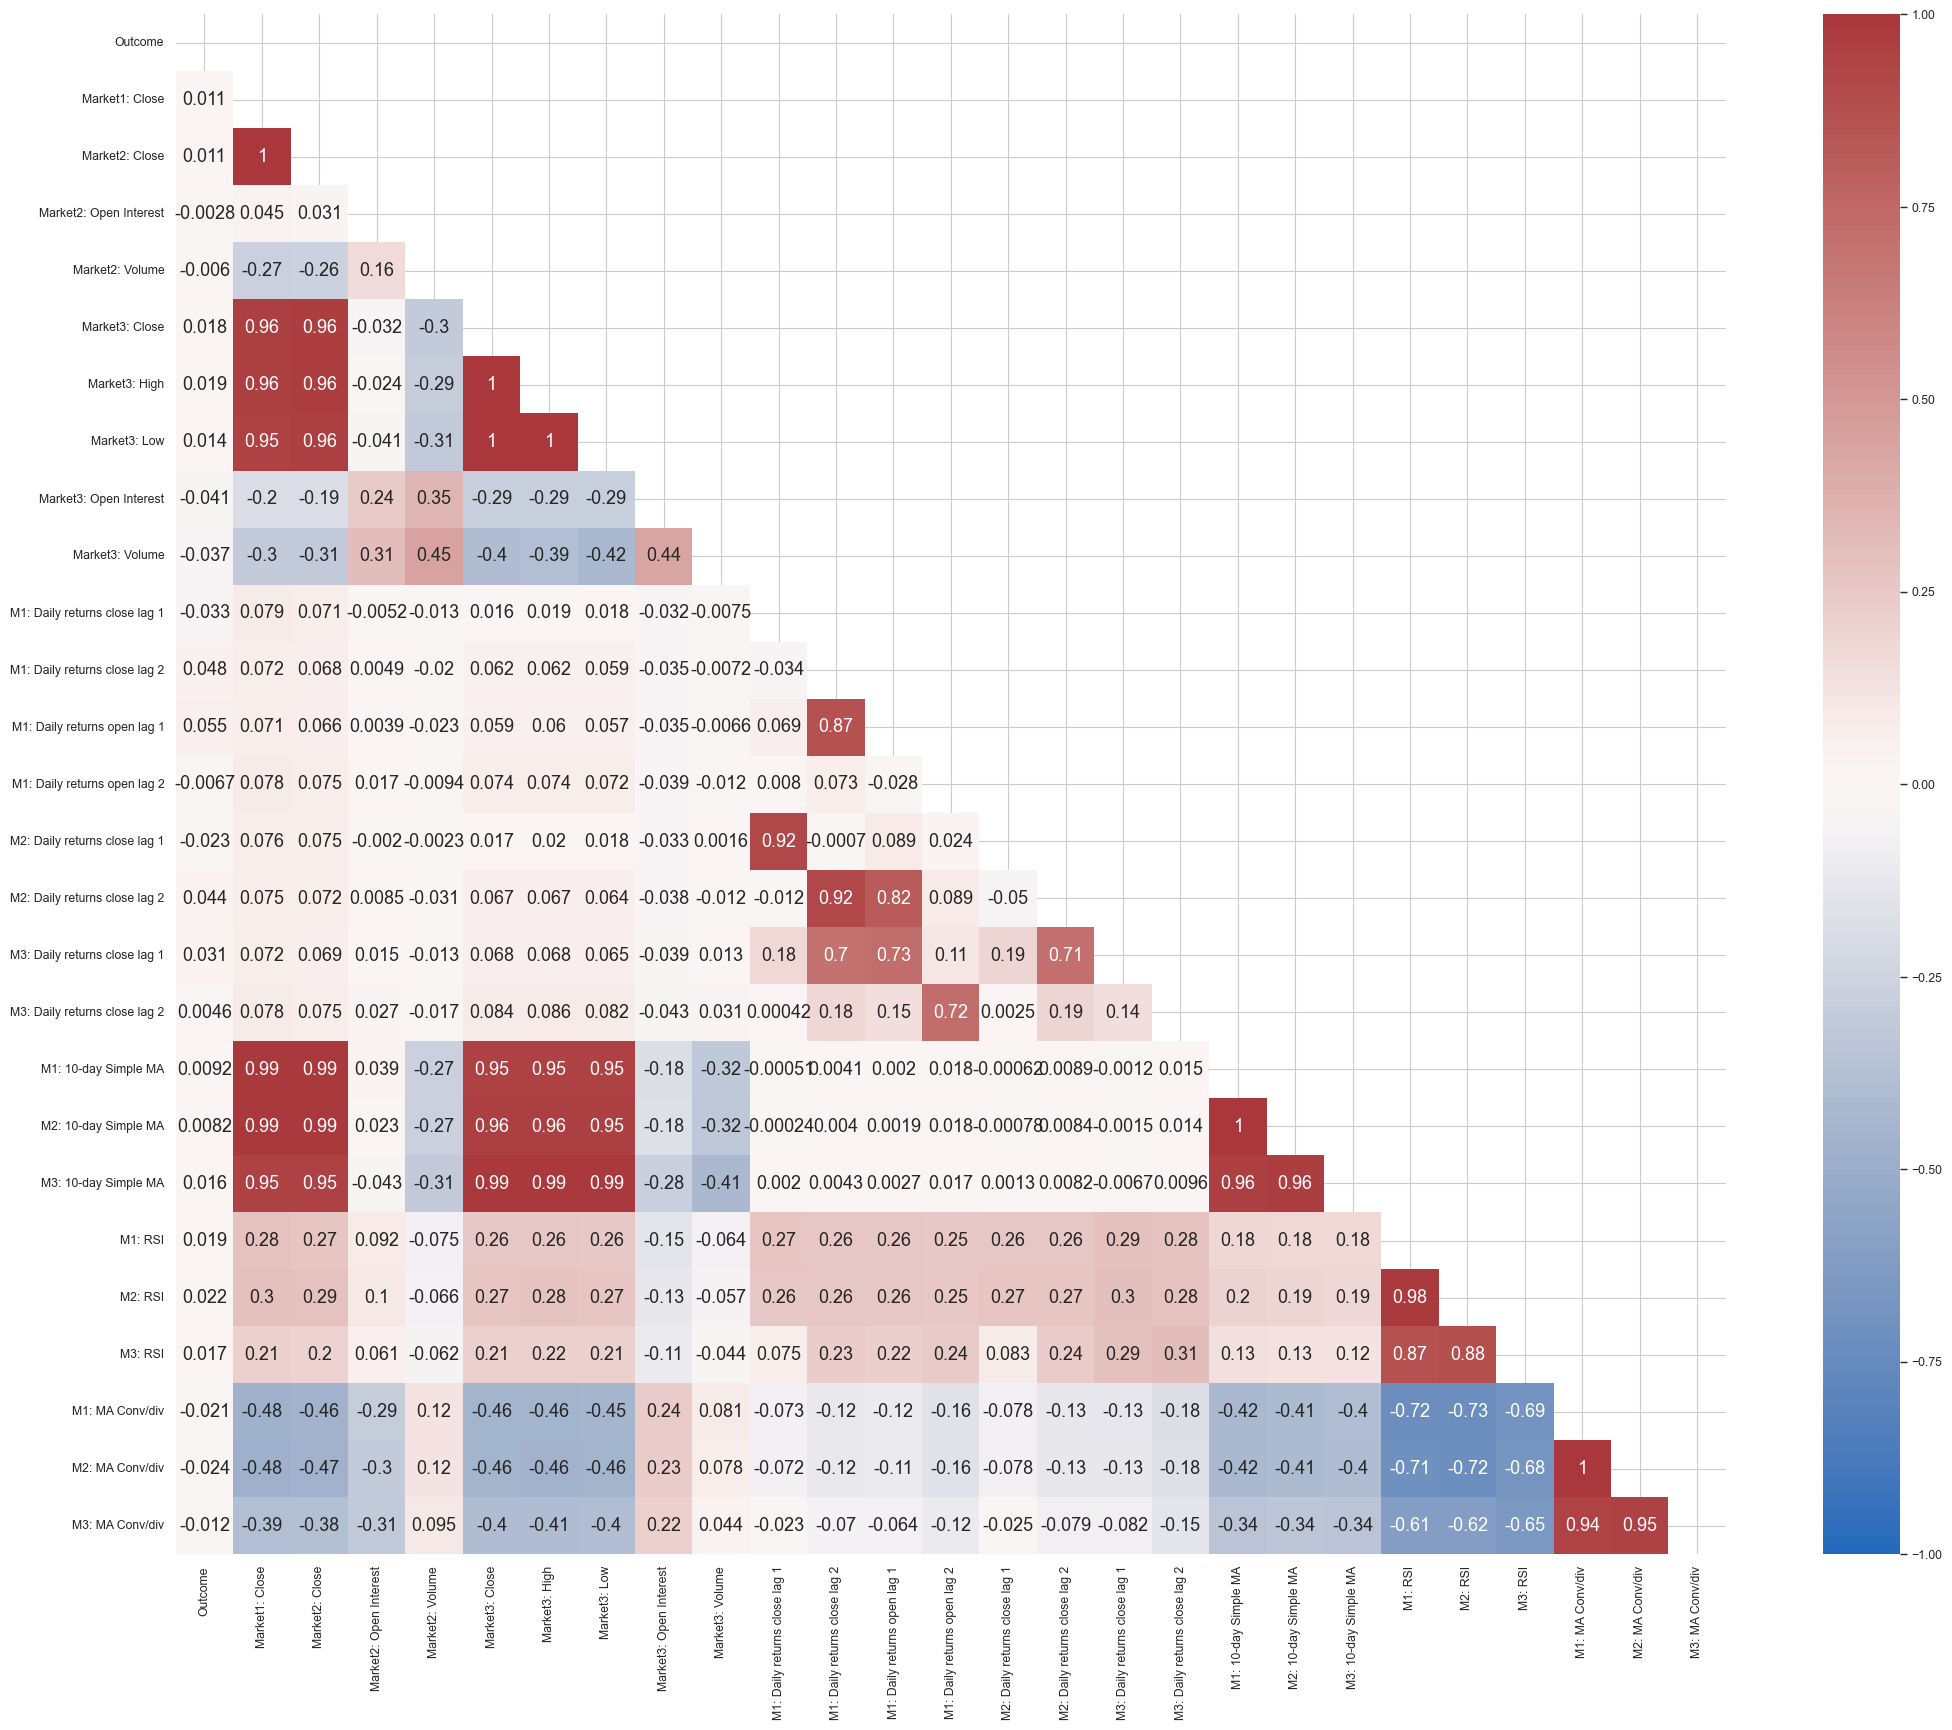

In [58]:
df_corr_cols = ['outcome', 'close_1', 'close_2', 'open_interest_2', 'volume_2', 
                'close_3', 'high_3', 'low_3', 'open_interest_3', 'volume_3',
                'return_cl_1_lag_1', 'return_cl_1_lag_2', 'return_op_1_lag_1', 'return_op_1_lag_2', 
                'return_cl_2_lag_1', 'return_cl_2_lag_2', 'return_cl_3_lag_1', 'return_cl_3_lag_2',
                'ma_1_10', 'ma_2_10', 'ma_3_10',
                'rsi_1', 'rsi_2', 'rsi_3', 
                'macd_1', 'macd_2', 'macd_3']
    
df_corr = df[df_corr_cols].copy().rename(cols_dict, axis=1)

plt.figure(figsize=(25, 20))
mask = np.triu(np.ones_like(df_corr.corr(), dtype=bool))
heatmap = sns.heatmap(df_corr.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='vlag', annot_kws={"size": 13})

# 5. Train-test split

In the following section, the dataset was split into train and validation set. Validation set consists of the latest 50 trading days. Depending on the type of technical indicator, some top values of these attributes are missing. Because of that, mentioned rows were removed from the dataset. Only some of the available features were used in the process of model training.

In [54]:
df.set_index('date', inplace=True)

In [180]:
df.columns

Index(['close_1', 'high_1', 'low_1', 'open_1', 'close_2', 'high_2', 'low_2',
       'open_2', 'open_interest_2', 'volume_2', 'close_3', 'high_3', 'low_3',
       'open_3', 'open_interest_3', 'volume_3', 'outcome', 'return_cl_1_lag_1',
       'return_cl_1_lag_2', 'return_op_1_lag_1', 'return_op_1_lag_2',
       'return_cl_2_lag_1', 'return_cl_2_lag_2', 'return_op_2_lag_1',
       'return_op_2_lag_2', 'return_cl_3_lag_1', 'return_cl_3_lag_2',
       'return_op_3_lag_1', 'return_op_3_lag_2', 'ma_1_1', 'ma_1_5', 'ma_1_10',
       'ma_1_20', 'ma_1_40', 'ma_2_1', 'ma_2_5', 'ma_2_10', 'ma_2_20',
       'ma_2_40', 'ma_3_1', 'ma_3_5', 'ma_3_10', 'ma_3_20', 'ma_3_40',
       'ema_1_1', 'ema_1_5', 'ema_1_10', 'ema_1_20', 'ema_1_40', 'ema_2_1',
       'ema_2_5', 'ema_2_10', 'ema_2_20', 'ema_2_40', 'ema_3_1', 'ema_3_5',
       'ema_3_10', 'ema_3_20', 'ema_3_40', 'rsi_1', 'rsi_2', 'rsi_3', 'macd_1',
       'macd_2', 'macd_3'],
      dtype='object')

In [82]:
df_model = df[['open_interest_3', 'volume_3', 'outcome', 'return_cl_1_lag_1',
                'return_cl_1_lag_2', 'return_op_1_lag_1', 
                'return_cl_2_lag_1', 'return_cl_2_lag_2', 'return_op_2_lag_1',
                'return_op_2_lag_2', 'return_cl_3_lag_1',
                'return_op_3_lag_1', 'return_op_3_lag_2', 'ma_1_1', 'ma_1_5', 'ma_1_10',
                'ma_1_20', 'ma_1_40', 'ma_2_1', 'ma_2_5', 'ma_2_10', 'ma_2_20',
               'ma_2_40', 'ma_3_1', 'ma_3_5', 'ma_3_10', 'ma_3_20', 'ma_3_40',
               'ema_1_1', 'ema_1_5', 'ema_1_10', 'ema_1_20', 'ema_1_40', 'ema_2_1',
               'ema_2_5', 'ema_2_10', 'ema_2_20', 'ema_2_40', 'ema_3_1', 'ema_3_5',
               'ema_3_10', 'ema_3_20', 'ema_3_40', 'rsi_1', 'rsi_2', 'rsi_3', 'macd_1',
               'macd_2', 'macd_3']].copy()

In [83]:
df_model.isna().any().sum()

49

In [92]:
df_model = df_model.loc[df_model.index[~df_model.isnull().any(axis=1)]]

In [93]:
# train test split
x_cols = df_model.columns.tolist()
x_cols.remove('outcome')
y, X = df_model['outcome'], df_model[x_cols]
X_train, X_test, y_train, y_test = X.iloc[:-50], X.iloc[-50:], y.iloc[:-50], y.iloc[-50:]
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1516, 48), (1516,), (50, 48), (50,))

In [94]:
X_train.isna().sum().sum()

0

In [95]:
X_test.isna().sum().sum()

0

# 6. Data standardization

In this part the train and test set were standardized using the mean and standard deviation calculated from training set. Standardization can be beneficial, because improves the numerical stability of the model and often reduces time of model building.

In [97]:
sc = StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.transform(X_test)

# 7. PCA

Because the analysed dataset contains many groups of correlated variables including daily returns, SMA & EMA and sets of the same technical indicators, it was decided to use PCA in order to reduce the data dimensionality. Principal Component Analysis combines correlated variables into a smaller set of linearly uncorrelated features. By doing so, it removes noises in the data and reduces model training time.

To select number of components which gives the best model performance, 20 logistic regression models with different number of principal components as variables were fitted. To asses model performance, the 5-cross-validation mean accuracy scores were calculated. The results are shown on the plot below. Based on that information, 2 principal components were selected as the best parameter, since the cross-validation accuracy exceeded 50% only for this number.

In [98]:
seed = 123

In [99]:
components_n = [int(x) for x in np.linspace(1, 20, 20, endpoint=True)]

lr = LogisticRegression(solver='liblinear', random_state=seed)
k_folds = KFold(n_splits=5)
test_acc = []

for n in components_n:
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(X_train_sc)
    scores = cross_val_score(lr, X_train_pca, y_train, cv=k_folds)
    test_acc.append(scores.mean())

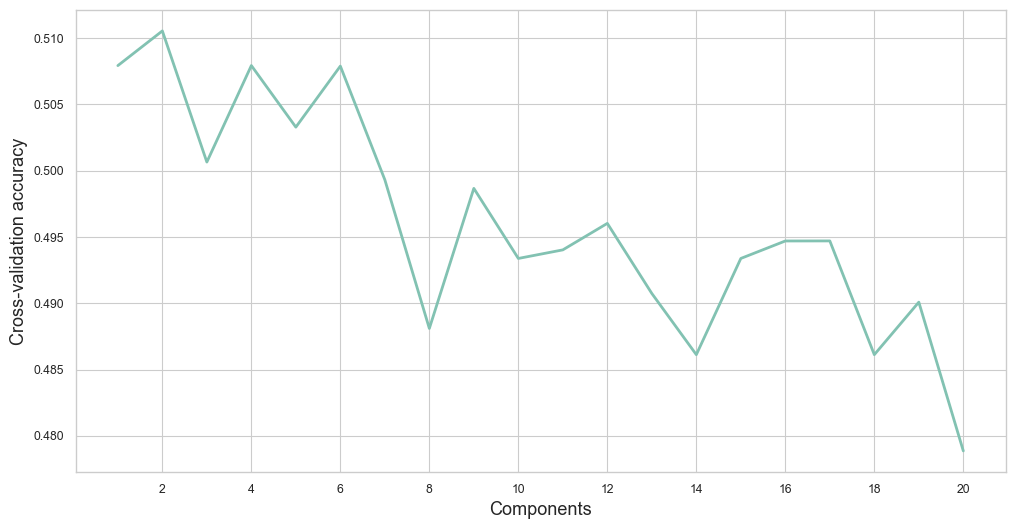

In [100]:
pca_data = pd.DataFrame({"Components": components_n, "Cross-validation accuracy": test_acc})

fig, axs = plt.subplots(1, 1, figsize=(12, 6))
ax = sns.lineplot(data=pca_data, x="Components", y="Cross-validation accuracy", linewidth=2)
ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

plt.show()

# 8. Logistic regression

The logistic regression is parametric method. It means that it assumes some functional form of the model. In logistic regression, a logit transformation is applied on the odds - ratio of the probability of success to the probability of failure.

To predict open-to-open price movements of commodity on 2nd market, the logistic regression model was built with use of 2 principal components as independent variables. The model accuracy ona  test set is 0.38. It means that model is able to predict only 38% of price movements correctly. Random classifier would be better in this case. The precision value of 0.5 says that when model predicts decrease in opening price, it is correct in 50% of the time. At the same time recall equal to 0.097 means that model correctly identifies 9.7% of all price growths. Specificity indicates that 84.2% of price drops were correctly identified by the model. The F1 score which measures both the precision and recall equals 16.2%.

## 8.1. With PCA

In [129]:
def model_perf_report(y, y_hat):
    acc = accuracy_score(y, y_hat)
    cf_matrix = confusion_matrix(y, y_hat)
    tn, fp, fn, tp = cf_matrix.ravel()
    precision = precision_score(y, y_hat)
    recall = recall_score(y, y_hat)
    specificity = tn / (tn + fp)
    f1 = f1_score(y, y_hat)
    print(f'Accuracy = {round(acc, 3)}',
         f'Precision = {round(precision, 3)}',
         f'Recall = {round(recall, 3)}',
         f'Specificity = {round(specificity, 3)}',
         f'F1 = {round(f1, 3)}', sep='\n')

In [131]:
pca = PCA(n_components = 2)
  
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)

classifier_pca = LogisticRegression(random_state = seed)
classifier_pca.fit(X_train_pca, y_train)

y_pred_lr_pca = classifier_pca.predict(X_test_pca)
model_perf_report(y_test, y_pred_lr_pca)

Accuracy = 0.38
Precision = 0.5
Recall = 0.097
Specificity = 0.842
F1 = 0.162


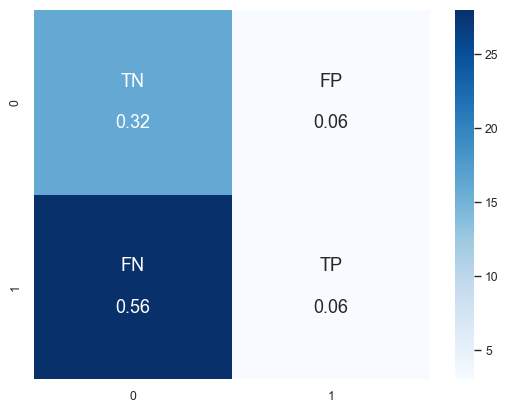

In [132]:
cf_matrix = confusion_matrix(y_test, y_pred_lr_pca)
group_names = ['TN','FP','FN','TP']
group_counts = [round(value, 3) for value in cf_matrix.flatten()/cf_matrix.sum()]
labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show()

## 8.1. Without PCA

To test a logistic regression model trained with use of 2 principal components, a model without PCA was created as a benchmark. The second model's accuracy ona test set is 0.44. It gives a little improvement but model is still worse than random classifier. The precision value of 1 says that when model predicts downward moves of opening price, it is correct in 100% of the time. At the same time recall equal to 0.097 means that model correctly identifies 9.7% of all price growths. Specificity indicates that 100% of price drops were correctly identified by the model. The F1 score which measures both the precision and recall equals 17.6%. All that results indicate that the model is rather conservative and predicts drops for most of the time. Moreover, using all the available features improves the model classification abilities.

In [133]:
classifier = LogisticRegression(random_state = seed)
classifier.fit(X_train_sc, y_train)

y_pred_lr = classifier.predict(X_test_sc)
model_perf_report(y_test, y_pred_lr)

Accuracy = 0.44
Precision = 1.0
Recall = 0.097
Specificity = 1.0
F1 = 0.176


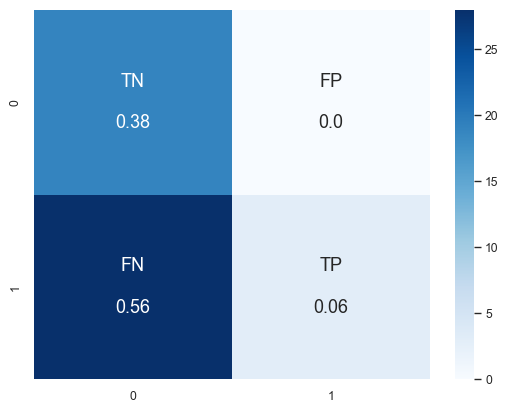

In [134]:
cf_matrix = confusion_matrix(y_test, y_pred_lr)
group_names = ['TN','FP','FN','TP']
group_counts = [round(value, 3) for value in cf_matrix.flatten()/cf_matrix.sum()]
labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show()

# 8. Random forest

It was deicded to built another, non-parametric model - random forest classifier to chceck if it will outperform the parametric logistic regression. Random forest was trained on the whole not standardized test set data, as this algorithm is robust on features with different scales and has built-in mechanism of indicating important predictors without favouring the strongest ones.

The model uses multiple decision trees and make a decision on the basis of majority vote. When constructing each node of decision tree, only a small part of all features is considered. It prevents model from using the same, strongest predictors when building the trees. As a result many uncorrelated decision trees are created which predictions are avaraged to obtain a final classification decision.

Before training the model, hyperparameter tuning was conducted to select the combination of model parameters giving the lowest cross-validation test error rate. It was done with use of randomized search, which search through random values selected from the parameter space we define. The method indicated a set of following optimal hyperparameters:

- number of trees in the forest: 100 
- method of calculating maximum number of features to consider at each split: log2 of total number of features
- maximum depth of tree: 2 levels
- minimum samples present in the leaf node: 5
- minimum number of observations to split the node: 10

## 8.1. Hyperparameter tuning

In [113]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(50, 500, 10, endpoint=True)]
# Number of features to consider at every split
max_features = ['log2', 'sqrt']
# Max number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 7, 6, endpoint=True)]
# Min number of observations allowed in a leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 20, 5, endpoint=True)]
# Min number of observations in a node before splitting the node
min_samples_split = [int(x) for x in np.linspace(5, 50, 10, endpoint=True)]

param_grid = {'n_estimators': n_estimators,
                'max_features': max_features,
                'max_depth': max_depth,
                'min_samples_leaf': min_samples_leaf,
                'min_samples_split': min_samples_split}

In [114]:
rf = RandomForestClassifier(random_state=seed)
rf_cv = RandomizedSearchCV(rf, param_grid, 
                           cv=5, verbose=2, n_iter = 40, 
                           random_state=seed, n_jobs = -1)
rf_cv.fit(X_train, y_train)
rf_cv.best_params_

Fitting 5 folds for each of 40 candidates, totalling 200 fits


{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'max_features': 'log2',
 'max_depth': 2}

## 8.2. Fitting the model

The trained random forest classifier gives similar accuracy as the logistic regression. The precision score is equal to 100%, recall equals 3.2% and specificity equals 100%. It means that 100% of price movements thought by the classifier to down up, actually went up. Value of recall says that out off all price growths, only 3.2% were correctly forecasted. Specificity indicates that 100% of price drops were classified to the correct class. The F1 score which measures the overall performance, including both the precision and recall equals 6.2%.

In [115]:
rf = rf_cv.best_estimator_
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=2, max_features='log2', min_samples_leaf=5,
                       min_samples_split=10, random_state=123)

In [116]:
y_train_pred = rf.predict(X_train)
y_pred_rf = rf.predict(X_test)

In [117]:
model_perf_report(y_test, y_pred_rf)

Accuracy = 0.4
Precision = 1.0
Recall = 0.032
Specificity = 1.0
F1 = 0.062


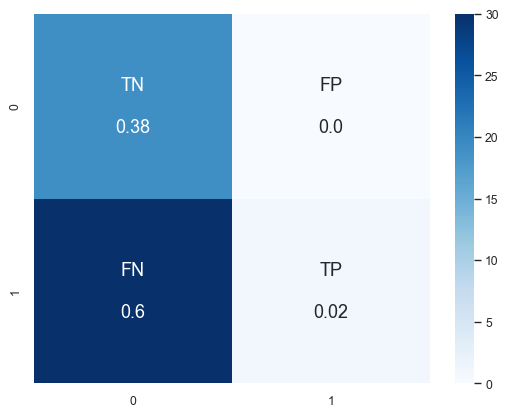

In [118]:
cf_matrix = confusion_matrix(y_test, y_pred_rf)
group_names = ['TN','FP','FN','TP']
group_counts = [round(value, 3) for value in cf_matrix.flatten()/cf_matrix.sum()]
labels = [f'{v1}\n\n{v2}' for v1, v2 in zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
plt.show()

## 8.3. Feature importances

Important insight we can gain from a random forest is to check which features turned out to be the most important in determining the stock movement direction. We can see that daily returns of price on 1st and 2nd market contribute to the model prediction of the future movement direction. The remaining important features includes RSI of 1st market, volume of 3rd market and open ineterst of commodity on 3rd market.

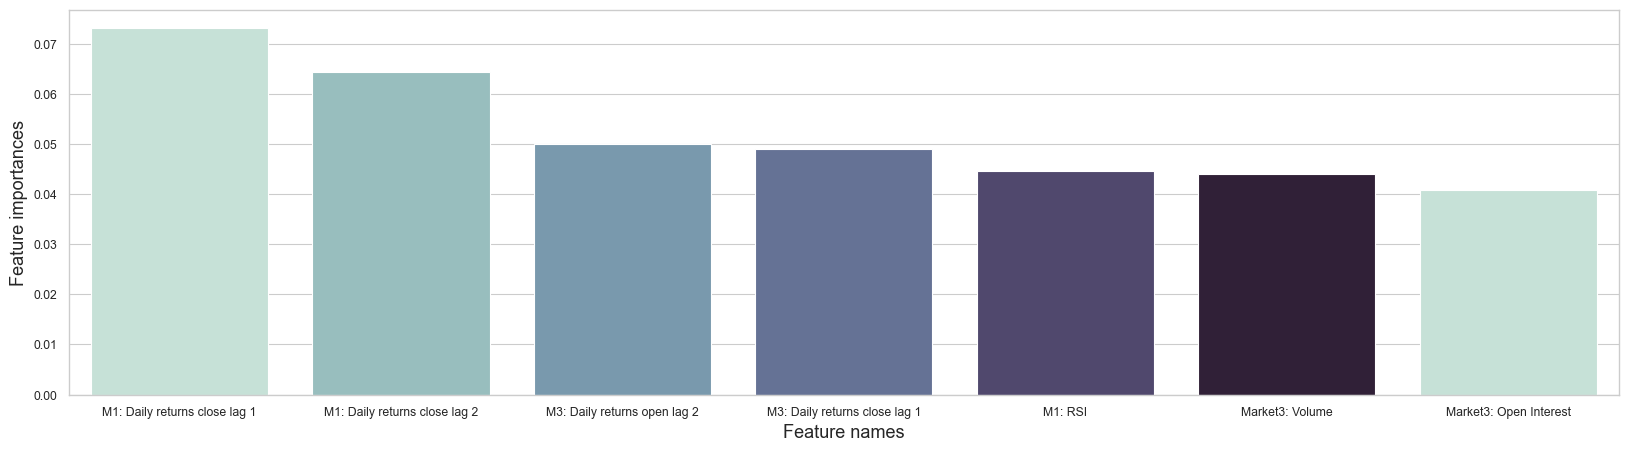

In [121]:
feature_names = X_test.columns
importances = rf.feature_importances_
imp_df = {'feature_names':feature_names, 'feature_importance': importances}
imp_df = pd.DataFrame(imp_df)
imp_df['feature_names'] = imp_df['feature_names'].map(cols_dict)

#Sort the DataFrame in order decreasing feature importance
imp_df.sort_values(by=['feature_importance'], ascending=False, inplace=True)
imp_df = imp_df[imp_df['feature_importance'] > 0.04]

#Define size of bar plot
plt.figure(figsize=(20,5))

#Plot Searborn bar chart
ax = sns.barplot(imp_df, y='feature_importance', x='feature_names', palette=sns.cubehelix_palette(start=.5, rot=-.5, as_cmap=False))
ax.set_ylabel("Feature importances")
ax.set_xlabel("Feature names")
plt.show()

## 8.4. Comparing models performance

On the plot below, it is easy to compare both models in terms of their prediction abilities. Logistic regression without features reduction obtained the best results aout of all 3 variants, but they are unpromising anyway. Each model has accuracy lower than 50% on the test set. It means that they are worse than random classifier. Although they are bad in predicting stock prices growth, they are conservative and usually predict drops of prices. Because of that, they are characterized by high specificity and precision. Nevertheless, all models should not be recommended as tools helping make investment decision as they evince a very poor ability to predict price growths.

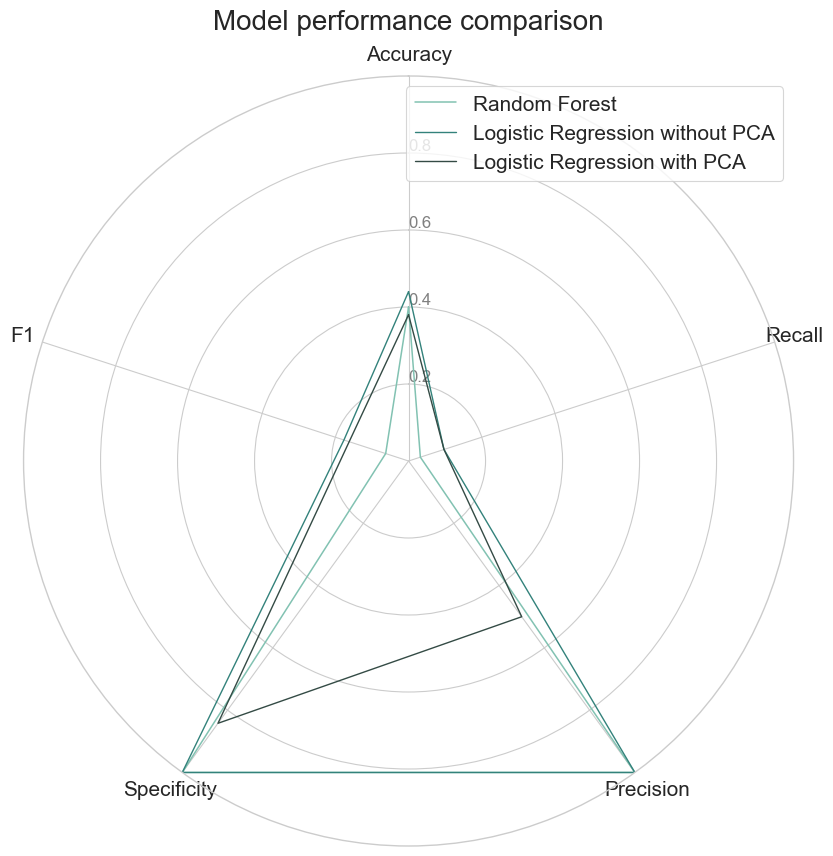

In [136]:
# https://www.python-graph-gallery.com/radar-chart/
categories = ['Accuracy', 'Recall', 'Precision', 'Specificity', 'F1']
N = len(categories)

angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

plt.figure(figsize=(10, 10))

ax = plt.subplot(111, polar=True)

ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.xticks(angles[:-1], categories, size=15)


ax.set_rlabel_position(0)
plt.yticks([0.2, 0.4, 0.6, 0.8], color="grey", size=12)
plt.ylim(0, 1)

cf_matrix = confusion_matrix(y_test, y_pred_rf)
tn, fp, fn, tp = cf_matrix.ravel()
values = [accuracy_score(y_test, y_pred_rf), 
             recall_score(y_test, y_pred_rf), 
             precision_score(y_test, y_pred_rf),
             tn / (tn + fp), 
             f1_score(y_test, y_pred_rf)]
values += values[:1]

ax.plot(angles, values, linewidth=1.1, linestyle='solid', label="Random Forest")

cf_matrix = confusion_matrix(y_test, y_pred_lr)
tn, fp, fn, tp = cf_matrix.ravel()
values = [accuracy_score(y_test, y_pred_lr), 
             recall_score(y_test, y_pred_lr), 
             precision_score(y_test, y_pred_lr),
             tn / (tn + fp), 
             f1_score(y_test, y_pred_lr)]

values += values[:1]

ax.plot(angles, values, linewidth=1, linestyle='solid', label="Logistic Regression without PCA")

cf_matrix = confusion_matrix(y_test, y_pred_lr_pca)
tn, fp, fn, tp = cf_matrix.ravel()
values = [accuracy_score(y_test, y_pred_lr_pca), 
             recall_score(y_test, y_pred_lr_pca), 
             precision_score(y_test, y_pred_lr_pca),
             tn / (tn + fp), 
             f1_score(y_test, y_pred_lr_pca)]

values += values[:1]

ax.plot(angles, values, linewidth=1, linestyle='solid', label="Logistic Regression with PCA")

plt.title('Model performance comparison', size=20, y=1.05)
plt.legend(prop={'size': 15})
plt.show()

# Conclusion

The aim of the following report was to introduce and compare two machine learning models which are meant to forecast the open to open price movement for the next day, based on the provided OHLC data. To do so, many technical indeces were estimated including daily returns, simple and exponential MA and relative stength index. First model, that is logistic regression, was trained with use of 2 variables resulted from performing PCA on the whole training dataset. The model obtained the test accuracy equal to 38%, precision of 50% and recall equal to 9.7%. The second model was logistic regression without features reduction. This model turned out to be be the best out of all 3 models in terms of the highest F1 score. However, the classifier performs very poorly, being able to predict only 44% of price movements accurately. The third model was a non-parametric random forest classifier which obtained 40% accuracy, 100% precision and recall equal to 3.2%. Also, the algorithm indicates the most powerful predictors in the task of price movmenets prediction, are daily returns and daily volume recorded at the 3rd Market. 

The poor performance of the analysed classifiers proves that predicting stock price movements is a difficult task. No correlation between past and current stock price movements indicates that stock market is driven by unpredictible forces. Obviously, the presented models should not be recommended as a tool helping investors in their financial decisions, as they are able to predict only most of the drops. Classifiers are incapable of predicting upward movements and they overall performance is worst than a naive random classifir. This project also indicates that including technical indices does not improve the model predictiveness.